In [24]:
!pip install chart_studio

     |████████████████████████████████| 71kB 2.2MB/s 


In [12]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


# Домашнее задание 3

## 0. Введение

Проблемой короновируса COVID-19 буквально сейчас заняты многие ученые по всему миру. В стороне не осталось и комьюнити Data scientist-ов, которые пытаются не просто предсказать развитие пандемии, а помочь определить наиболее значимые факторы, влияющие на распространение заразы. Например на небезызвестном [Kaggle](https://www.kaggle.com/tags/covid19).

В данной домашней работе Вы будете использовать ежедневно обновляемые данные из [репозитория](https://github.com/datasets/covid-19), а конкретно [time-series-19-covid-combined.csv](https://github.com/datasets/covid-19/blob/master/data/time-series-19-covid-combined.csv).

Вам предстоит изучить имеющиеся данные, попробовать найти некоторые закономерности и ответить на вопросы. Ниже представлены задания как исследовательского характера, где приветствуется инициативность, так и чисто тренировочного харатера - где необходимо использовать изученные на семинаре инструменты для работы с временными рядами. **Не забывайте сопровождать ваш код развернутыми комментариями и выводами.** Чем их больше и чем они качественнее, тем лучше и выше вероятность получения максимальной оценки за домашнее задание. Не болейте!

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sma
import statsmodels.formula.api as smfa
import statsmodels.tsa.stattools as smstt
%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv')
df.head()

Date Country/Region Province/State   Lat  Long  Confirmed  Recovered  \
0  2020-01-22    Afghanistan            NaN 33.00 65.00       0.00       0.00   
1  2020-01-23    Afghanistan            NaN 33.00 65.00       0.00       0.00   
2  2020-01-24    Afghanistan            NaN 33.00 65.00       0.00       0.00   
3  2020-01-25    Afghanistan            NaN 33.00 65.00       0.00       0.00   
4  2020-01-26    Afghanistan            NaN 33.00 65.00       0.00       0.00   

   Deaths  
0    0.00  
1    0.00  
2    0.00  
3    0.00  
4    0.00

In [3]:
df = df.rename(columns={'Country/Region':'Country'})
df = df.rename(columns={'Province/State':'Province'})

In [4]:
df.describe()

Lat     Long  Confirmed  Recovered   Deaths
count 27132.00 27132.00   27030.00   25704.00 27030.00
mean     21.47    22.03    2975.22     838.60   193.03
std      24.76    70.77   28488.30    6520.69  1970.62
min     -51.80  -135.00       0.00       0.00     0.00
25%       7.00   -23.04       0.00       0.00     0.00
50%      23.66    20.92       9.00       0.00     0.00
75%      41.20    78.00     245.00      50.00     3.00
max      71.71   178.06 1132539.00  175382.00 66369.00

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27132 entries, 0 to 27131
Data columns (total 8 columns):
Date         27132 non-null object
Country      27132 non-null object
Province     8364 non-null object
Lat          27132 non-null float64
Long         27132 non-null float64
Confirmed    27030 non-null float64
Recovered    25704 non-null float64
Deaths       27030 non-null float64
dtypes: float64(5), object(3)
memory usage: 1.7+ MB


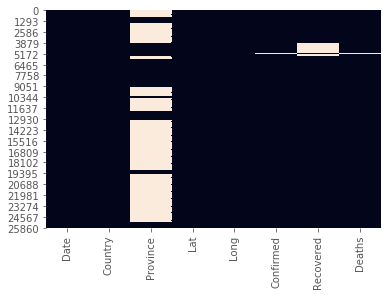

In [6]:
# Много пропусков в провинциях, так как в большинстве представлены агрегированные даные по странам, также для некоторых 
# стран пропущены данные о кейсах

import seaborn as sns
sns.heatmap(df.isnull(), cbar=False); 

In [7]:
df.Country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

## 1. Exploratory data analysis

#### 1.1 Определите границы исследуемого периода, количество заболевших, погибших, выздоровивших. Отобразите на карте распространение болезни.

In [8]:
start_date = min(set(df.Date))
last_date = max(set(df.Date))
print("Границы исследуемого периода {} : {}".format(start_date, last_date))

Границы исследуемого периода 2020-01-22 : 2020-05-02


In [9]:
df_last_date = df[df["Date"] == last_date]
print("На момент {} заболевших {} в {} странах".format(last_date, np.sum(df_last_date["Confirmed"]), len(set(df_last_date["Country"]))))
print("На момент {} выздоровивших {} в {} странах".format(last_date, np.sum(df_last_date["Recovered"]), len(set(df_last_date["Country"]))))
print("На момент {} погибших {} в {} странах".format(last_date, np.sum(df_last_date["Deaths"]), len(set(df_last_date["Country"]))))

На момент 2020-05-02 заболевших 3427343.0 в 187 странах
На момент 2020-05-02 выздоровивших 1093112.0 в 187 странах
На момент 2020-05-02 погибших 243808.0 в 187 странах


In [10]:
df_countrydate = df[df['Confirmed']>0]
df_countrydate = df_countrydate.groupby(['Date','Country']).sum().reset_index()
df_countrydate.head()

Date       Country    Lat    Long  Confirmed  Recovered  Deaths
0  2020-01-22         China 743.86 2723.06     548.00      28.00   17.00
1  2020-01-22         Japan  36.00  138.00       2.00       0.00    0.00
2  2020-01-22  Korea, South  36.00  128.00       1.00       0.00    0.00
3  2020-01-22       Taiwan*  23.70  121.00       1.00       0.00    0.00
4  2020-01-22      Thailand  15.00  101.00       2.00       0.00    0.00

In [11]:
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

Рассмотрим распространение короновируса, то есть построим анимированный график по дням 

**NB!** Этот график не запускается у меня в коллабе, но работает в ноутбуках (:

Можем заметить, как регистрируются первые случаи в Китае, далее зараженных обнаруживают в Тайланде, Японии, США, и к концу временного периода не остается стран, в которых нет подтвержденных кейсов. 

In [12]:
fig = px.choropleth(df_countrydate, 
                    locations="Country", 
                    locationmode = "country names",
                    color="Confirmed", 
                    hover_name="Country", 
                    animation_frame="Date"
                   )
fig.update_layout(
    title_text = 'Spread of COVID-19',
    title_x = 0.5,
    geo=dict(
        showframe = False,
        showcoastlines = False,
    ))
    
fig.show()

Также построим "статичные" графики для отображения ситуации на последний день в датасете.

In [13]:
date_all = df[df["Date"] == last_date]
date_all = date_all[["Country", "Confirmed", "Deaths", "Recovered", "Lat", "Long"]]
date_all = date_all.dropna()
# Для лучшей визуализации отшкалируем значение подтвержденных случаев, разделив его на 100. 
size2 = list((date_all["Confirmed"]/100).astype(float)) 
size3 = list((date_all["Deaths"]/100).astype(float))

In [14]:
import plotly.graph_objects as go
figure = go.Figure()

for i in date_all:
   
    figure.add_trace(go.Scattergeo(
        lon = date_all['Long'],
        lat = date_all['Lat'],
        text = date_all['Country'],
        
         marker = dict(
           size = size2,
            color = 'rgb(230, 0, 0)',
            line_color = 'rgb(162, 15, 14)',
            line_width = 0,
            opacity=0.3,
            sizemode= 'area'
        )
    ))
    
    figure.update_layout(
        title_text = 'COVID-19 Confirmed cases',
        showlegend = False,
        geo = dict(
            scope='world',
            resolution=110,
            showframe = False,
            showcoastlines=True,
            showocean=False,
            countrycolor='#2a2a28',
            coastlinecolor='#224354',
            landcolor='#224354',
        )
    )
figure.show()

In [15]:
figure = go.Figure()

for i in date_all:
   
    figure.add_trace(go.Scattergeo(
        lon = date_all['Long'],
        lat = date_all['Lat'],
        text = date_all['Country'],
        
         marker = dict(
           size = size3,
            color = 'rgb(100, 14, 82)',
            line_color = 'rgb(166, 100, 82)',
            line_width = 0,
            opacity=0.5,
            sizemode= 'area'
        )
    ))
    
    figure.update_layout(
        title_text = 'COVID-19 Deaths',
        showlegend = False,
        geo = dict(
            scope='world',
            resolution=110,
            showframe = False,
            showcoastlines=True,
            showocean=False,
            countrycolor='#2a2a28',
            coastlinecolor='#224354',
            landcolor='#224354'
        )
    )
figure.show()

#### 1.2 Определите количество стран, которые подтвердили случаи заражения. Визуализируйте рост количества стран, подтвердивших случаи заражения по дням (или неделям). 

  *Примечание. В анализе временных рядов иногда необходимо изменить частоту дискретизации (Resampling). Такая операция может понадобится, когда имеющихся данных недостаточно или их, наоборот, слишком много. Может не устраивать имеющаяся частота или просто хочется посмотреть на данные с более общего ракурса.*

  *Различают два вида изменения частоты: повышение (Upsampling) и понижение (Downsampling). При повышении временной ряд пересчитывается с низкой частоы на более высокую частоту (например от годовой до месячной частоты). В таком случае процесс включает в себя заполнение или интерполяцию появившихся пропусков в данных. При понижении временной ряд передискретизируется с высокой частоты на низкую (наример с еженедельной на месячную частоту). Это включает в себя агрегацию существующих данных.*

In [16]:
df_countrydate2 = df_countrydate.sort_values('Date', ascending=False)[["Country", "Date"]].groupby("Date").count().reset_index()
df_countrydate3 = df_countrydate.sort_values('Date', ascending=False)[["Country", "Date"]].groupby("Date").count()
df_countrydate2.tail()

Date  Country
97   2020-04-28      185
98   2020-04-29      185
99   2020-04-30      187
100  2020-05-01      187
101  2020-05-02      187

Рассмотрим рост количества стран с подтвержденными случаими короновируса. Можем заметить, как с начала рассматриваемого периода и до 23 февраля прирост количества стран с подтвержеднными случаими COVID-19 рос постепенно, а после 23 февраля стал значитнльно круче. 23 марта наметилось сокращение прироста, так как почти все страны стали подвержены вирусу.

In [17]:
fig = px.line(df_countrydate2, x = "Date", y = "Country")

fig.update_layout(
    title="COVID-19: countries with confirmed cases",
    xaxis_title="Date",
    yaxis_title="Confirmed cases",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

Рассмотрим также рост новых стран, в которых обноружили короновирус, по неделям, для этого создадим новую переменную и воспользуемся downsampling'ом -- выберем каждое 7ое значение. 

Мы получили график аналогичный предыдущему, но более гладкий. 

In [19]:
week_date = df_countrydate2[::7]
week_date

Date  Country
0   2020-01-22        6
7   2020-01-29       18
14  2020-02-05       26
21  2020-02-12       27
28  2020-02-19       29
35  2020-02-26       47
42  2020-03-04       81
49  2020-03-11      112
56  2020-03-18      150
63  2020-03-25      174
70  2020-04-01      180
77  2020-04-08      184
84  2020-04-15      185
91  2020-04-22      185
98  2020-04-29      185

In [21]:
fig = px.line(week_date, x = "Date", y = "Country")

fig.update_layout(
    title="COVID-19: countries with confirmed cases, weekly data",
    xaxis_title="Date",
    yaxis_title="Confirmed cases",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

#### 1.3 Визуализируйте мировые тренды по числу заболевших | погибших | выздоровивших. Постройте графики, которые отражают летальность от вируса в разных странах или на разных континентах. 

In [22]:
df2 = df_countrydate.sort_values('Date', ascending=False)[["Date", "Confirmed", "Recovered", "Deaths"]].groupby("Date").sum().reset_index()
df2.head()

Date  Confirmed  Recovered  Deaths
0  2020-01-22     555.00      28.00   17.00
1  2020-01-23     654.00      30.00   18.00
2  2020-01-24     941.00      36.00   26.00
3  2020-01-25    1434.00      39.00   42.00
4  2020-01-26    2118.00      52.00   56.00

In [23]:
fig = go.Figure()

fig.add_trace(go.Scatter(x= df2["Date"], y=df2["Confirmed"],
                    mode='lines',
                    name='Confirmed cases'))

fig.add_trace(go.Scatter(x= df2["Date"], y=df2["Deaths"],
                    mode='lines',
                    name='Deaths'))

fig.add_trace(go.Scatter(x= df2["Date"], y=df2["Recovered"],
                    mode='lines',
                    name='Recovered'))


fig.update_layout(
    title="COVID-19: world trend",
    xaxis_title="Date",
    yaxis_title="Confirmed cases",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

Отметим, что после 15 марта прирост показатели подтвержденных случаев, смертей и выздоровлений значительно ускорился, при этом прирост выздоровлений больше, чем прирост смертей.

Рассмотрим показатель смертности: в динамике и на момент последнего дня в датасете. 

In [32]:
# Рассмотрим летальность 
df_countrydate["mortality_rate"] = (df_countrydate["Deaths"]/df_countrydate["Confirmed"])*100
df_countrydate.head()

Date       Country    Lat    Long  Confirmed  Recovered  Deaths  \
0  2020-01-22         China 743.86 2723.06     548.00      28.00   17.00   
1  2020-01-22         Japan  36.00  138.00       2.00       0.00    0.00   
2  2020-01-22  Korea, South  36.00  128.00       1.00       0.00    0.00   
3  2020-01-22       Taiwan*  23.70  121.00       1.00       0.00    0.00   
4  2020-01-22      Thailand  15.00  101.00       2.00       0.00    0.00   

   mortality_rate  
0            3.10  
1            0.00  
2            0.00  
3            0.00  
4            0.00

In [33]:
# Так как график по всем странам неинформативен, рассмотрим лишь некоторые страны. 
df_countrydate_filtered = df_countrydate[(df_countrydate["Country"] == "China")|
                                        (df_countrydate["Country"] == "US") |
                                        (df_countrydate["Country"] == "Italy")|
                                        (df_countrydate["Country"] == "Germany")|
                                        (df_countrydate["Country"] == "Lebanon") |
                                        (df_countrydate["Country"] == "Korea, South") |
                                        (df_countrydate["Country"] == "Japan") |
                                        (df_countrydate["Country"] == "Tunisia") |
                                        (df_countrydate["Country"] == "Thailand") |
                                        (df_countrydate["Country"] == "Kenya") | 
                                        (df_countrydate["Country"] == "Island") | 
                                        (df_countrydate["Country"] == "Israel") | 
                                        (df_countrydate["Country"] == "France") | 
                                        (df_countrydate["Country"] == "Russia")]
df_countrydate_filtered = df_countrydate_filtered[::7]

In [35]:
fig = px.line(df_countrydate_filtered, x="Date", y="mortality_rate", color="Country")

fig.update_layout(
    title="COVID-19: mortality rate, selected countries",
    xaxis_title="Date",
    yaxis_title="Mortality rate",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.update_xaxes(rangeslider_visible=True)

fig.show()

Также рассмотрим данные по регионам. 

In [36]:
regions = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")
regions = regions.rename(columns = {"name": "Country"})
regions = regions[["Country", "region"]]
regions.head()

Country   region
0     Afghanistan     Asia
1   Åland Islands   Europe
2         Albania   Europe
3         Algeria   Africa
4  American Samoa  Oceania

In [37]:
regions.Country[regions["Country"] == "United States of America"] = "US"

In [38]:
regions_date = df_countrydate.merge(regions)
regions_date = regions_date.groupby(["region", "Date"])["Confirmed", "Recovered", "Deaths"].sum()
regions_date = regions_date.reset_index()
regions_date["Mortality_rate"] = (regions_date["Deaths"]/regions_date["Confirmed"])*100
regions_date.head()

region        Date  Confirmed  Recovered  Deaths  Mortality_rate
0  Africa  2020-02-14       1.00       0.00    0.00            0.00
1  Africa  2020-02-15       1.00       0.00    0.00            0.00
2  Africa  2020-02-16       1.00       0.00    0.00            0.00
3  Africa  2020-02-17       1.00       0.00    0.00            0.00
4  Africa  2020-02-18       1.00       0.00    0.00            0.00

In [39]:
fig = px.line(regions_date, x="Date", y="Mortality_rate", color="region")

fig.update_layout(
    title="COVID-19: world trend",
    xaxis_title="Date",
    yaxis_title="Mortality rate",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.update_xaxes(rangeslider_visible=True)

fig.show()

Как мы видим, наименьше всего уровень смертности в Океании и Азии, при этом сначала наблюдается резкий рост смертности, после -- небольшое уменьшение, и дальше опять рост или замедление роста. 

In [40]:
# Также посмотрим на данные по летальности на последний момент в датасете 
last_date_regions = df_countrydate.merge(regions)
last_date_regions2 = last_date_regions[last_date_regions["Date"] == last_date]

In [41]:
fig = px.bar(last_date_regions2, x = "Country", y = "mortality_rate", color = "region")

fig.update_layout(
    title="COVID-19: mortality rate by countries {}".format(last_date),
    xaxis_title="Country",
    yaxis_title="Mortality rate",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

In [31]:
# Дополнительно визуализируем это на карте 
df_countrydate_last = df_countrydate[df_countrydate["Date"] == last_date] 
figure = go.Figure()

for i in df_countrydate:
   
    figure.add_trace(go.Scattergeo(
        lon = df_countrydate_last['Long'],
        lat = df_countrydate_last['Lat'],
        text = df_countrydate_last['Country'],
        
         marker = dict(
           size = (df_countrydate_last["mortality_rate"])*10,
            color = 'rgb(230, 0, 0)',
            line_color = 'rgb(162, 15, 14)',
            line_width = 0,
            opacity=0.3,
            sizemode= 'area'
        )
    ))
    
    figure.update_layout(
        title_text = 'COVID-19: Mortality_rate',
        showlegend = False,
        geo = dict(
            scope='world',
            resolution=110,
            showframe = False,
            showcoastlines=True,
            showocean=False,
            countrycolor='#2a2a28',
            coastlinecolor='#224354',
            landcolor='#224354',
        )
    )
figure.show()

#### 1.4 Визуализируйте и сравните, как распространялась болезнь в разных странах или континентах по дням с первого зарегистрированного случая заболевания. Определите количество дней для каждой страны со дня первого зарегестрированного случая.

Для наиболее удобного сравнения будем сопоставлять распространение вируса в странах со дня первого зарегистированного случая.

In [53]:
df_countrydate2 = df_countrydate.groupby(['Date','Country']).sum().reset_index()
df_countrydate2.head()

Date       Country    Lat    Long  Confirmed  Recovered  Deaths  \
0  2020-01-22         China 743.86 2723.06     548.00      28.00   17.00   
1  2020-01-22         Japan  36.00  138.00       2.00       0.00    0.00   
2  2020-01-22  Korea, South  36.00  128.00       1.00       0.00    0.00   
3  2020-01-22       Taiwan*  23.70  121.00       1.00       0.00    0.00   
4  2020-01-22      Thailand  15.00  101.00       2.00       0.00    0.00   

   mortality_rate  
0            3.10  
1            0.00  
2            0.00  
3            0.00  
4            0.00

In [54]:
def confirmed_case(data, number): 
    df_conf = data[data["Confirmed"] >= number]
    case_date = data.loc[pd.to_datetime(data['Date']).idxmin()]
    return case_date["Date"]

In [55]:
def calcul_dates_since(data, frst_case_date): 
    df = df[['Date', 'Country']].copy()
    df["Days_since"] = df['Date'].map(lambda date: (pd.to_datetime(date) - pd.to_datetime(frst_case_date)).days)
    return df

In [50]:
countries = list(set(df_countrydate2["Country"]))
frst_date = []
for i in countries: 
    frst_date.append(confirmed_case(df_countrydate2[df_countrydate2["Country"] == i], 0))

frst_cases = pd.DataFrame({"Country": countries, 
                          "Frst_case": frst_date})
df_countrydate3 = df_countrydate2.merge(frst_cases)

df_countrydate3.head()

Date Country     Lat    Long  Confirmed  Recovered  Deaths  \
0  2020-01-22   China  743.86 2723.06     548.00      28.00   17.00   
1  2020-01-23   China  971.81 3386.39     643.00      30.00   18.00   
2  2020-01-24   China 1015.90 3500.33     920.00      36.00   26.00   
3  2020-01-25   China 1051.64 3596.33    1406.00      39.00   42.00   
4  2020-01-26   China 1051.64 3596.33    2075.00      49.00   56.00   

   mortality_rate   Frst_case  
0            3.10  2020-01-22  
1            2.80  2020-01-22  
2            2.83  2020-01-22  
3            2.99  2020-01-22  
4            2.70  2020-01-22

In [51]:
days_since_frst = []
for _, row in df_countrydate3.iterrows():
    days_since_frst.append((pd.to_datetime(row["Date"]) - pd.to_datetime(row["Frst_case"])).days)

df_countrydate3["days_since_frst"] = days_since_frst
df_countrydate3

Date     Country     Lat    Long  Confirmed  Recovered  Deaths  \
0      2020-01-22       China  743.86 2723.06     548.00      28.00   17.00   
1      2020-01-23       China  971.81 3386.39     643.00      30.00   18.00   
2      2020-01-24       China 1015.90 3500.33     920.00      36.00   26.00   
3      2020-01-25       China 1051.64 3596.33    1406.00      39.00   42.00   
4      2020-01-26       China 1051.64 3596.33    2075.00      49.00   56.00   
...           ...         ...     ...     ...        ...        ...     ...   
11124  2020-05-01     Comoros  -11.65   43.33       1.00       0.00    0.00   
11125  2020-05-02     Comoros  -11.65   43.33       3.00       0.00    0.00   
11126  2020-04-30  Tajikistan   38.86   71.28      15.00       0.00    0.00   
11127  2020-05-01  Tajikistan   38.86   71.28      15.00       0.00    0.00   
11128  2020-05-02  Tajikistan   38.86   71.28      76.00       0.00    2.00   

       mortality_rate   Frst_case  days_since_frst  
0                3.10  2020-01-22                0  
1                2.80  2020-01-22                1  
2                2.83  2020-01-22                2  
3                2.99  2020-01-22                3  
4                2.70  2020-01-22                4  
...               ...         ...              ...  
11124            0.00  2020-04-30                1  
11125            0.00  2020-04-30                2  
11126            0.00  2020-04-30                0  
11127            0.00  2020-04-30                1  
11128            2.63  2020-04-30                2  

[11129 rows x 10 columns]

In [52]:
fig = px.line(df_countrydate3, x="days_since_frst", y="Confirmed", color="Country")

fig.update_layout(
    title="COVID-19: world trend (days since first confirmed case)",
    xaxis_title="Days since first case",
    yaxis_title="Confirmed cases",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

Можно заметить, что все страны развиваются по примерно одинаковому сценарию, но на графике это не очень наглядно, так как показатели подтвержденных случаев в некоторых странах, например, в США, сильно превосходят остальные. Логарифмируем показатель подтвержденных случаев. 

In [56]:
df_countrydate3["Confirmed_log"] = np.log(df_countrydate3["Confirmed"])
df_countrydate3.head()

Date Country     Lat    Long  Confirmed  Recovered  Deaths  \
0  2020-01-22   China  743.86 2723.06     548.00      28.00   17.00   
1  2020-01-23   China  971.81 3386.39     643.00      30.00   18.00   
2  2020-01-24   China 1015.90 3500.33     920.00      36.00   26.00   
3  2020-01-25   China 1051.64 3596.33    1406.00      39.00   42.00   
4  2020-01-26   China 1051.64 3596.33    2075.00      49.00   56.00   

   mortality_rate   Frst_case  days_since_frst  Confirmed_log  
0            3.10  2020-01-22                0           6.31  
1            2.80  2020-01-22                1           6.47  
2            2.83  2020-01-22                2           6.82  
3            2.99  2020-01-22                3           7.25  
4            2.70  2020-01-22                4           7.64

In [57]:
# Выделим некоторые страны для удобства визуализации 
df_countrydate4 = df_countrydate3[::7]

# Так как график по всем странам неинформативен, рассмотрим лишь некоторые страны. 
df_countrydate4 = df_countrydate4[(df_countrydate4["Country"] == "China")|
                                        (df_countrydate4["Country"] == "US") |
                                        (df_countrydate4["Country"] == "Italy")|
                                        (df_countrydate4["Country"] == "Germany")|
                                        (df_countrydate4["Country"] == "Lebanon") |
                                        (df_countrydate4["Country"] == "Korea, South") |
                                        (df_countrydate4["Country"] == "Japan") |
                                        (df_countrydate4["Country"] == "Tunisia") |
                                        (df_countrydate4["Country"] == "Thailand") |
                                        (df_countrydate4["Country"] == "Kenya") | 
                                        (df_countrydate4["Country"] == "Island") | 
                                        (df_countrydate4["Country"] == "Israel") | 
                                        (df_countrydate4["Country"] == "France") | 
                                        (df_countrydate4["Country"] == "Russia") |
                                        (df_countrydate4["Country"] == "Canada")]

In [58]:
fig = px.line(df_countrydate4, x="days_since_frst", y="Confirmed_log", color="Country")

fig.update_layout(
    title="COVID-19: world trend (days since first confirmed case)",
    xaxis_title="Days since first case",
    yaxis_title="Confirmed cases log",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

Итак, можно заметить, что ситуация с заболевшими во всех странах развивается по схожему паттерну.

#### 1.5 Визуализируйте и оцените как развивалась ситуация в России по сравнению с остальными миром.

In [59]:
df_countrydate2 = df_countrydate.sort_values('Date', ascending=False)[["Country", "Date"]].groupby("Date").count().reset_index()
counts_c = df_countrydate2.rename(columns = {"Country":"Country_count"})
df_countrydate5 = df_countrydate3.groupby("Date").sum().reset_index()
df_countrydate5["Level"] = "World"
russia = df_countrydate3[df_countrydate3["Country"] == "Russia"]
russia["Level"] = "Russia"
russia_world = pd.concat([df_countrydate5, russia])
russia_world.head()

Confirmed  Confirmed_log Country        Date  Deaths Frst_case     Lat  \
0     555.00           7.69     NaN  2020-01-22   17.00       NaN  891.65   
1     654.00           8.95     NaN  2020-01-23   18.00       NaN 1136.88   
2     941.00          14.10     NaN  2020-01-24   26.00       NaN 1227.20   
3    1434.00          16.36     NaN  2020-01-25   42.00       NaN 1293.61   
4    2118.00          21.15     NaN  2020-01-26   56.00       NaN 1273.18   

   Level    Long  Recovered  days_since_frst  mortality_rate  
0  World 3115.35      28.00                0            3.10  
1  World 3990.51      30.00                6            2.80  
2  World 4106.67      36.00               14            2.83  
3  World 4399.41      39.00               23            2.99  
4  World 4610.26      52.00               34            2.70

In [64]:
fig = px.line(russia_world, x="Date", y="Confirmed", color = "Level")

fig.update_layout(
    title="COVID-19: world trend vs Russia trend (absolute values)",
    xaxis_title="Date",
    yaxis_title="Confirmed cases log",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

In [61]:
fig = px.line(russia_world, x="Date", y="Deaths", color = "Level")

fig.update_layout(
    title="COVID-19: world trend vs Russia trend (absolute values)",
    xaxis_title="Date",
    yaxis_title="Confirmed cases log",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

In [62]:
fig = px.line(russia_world, x="Date", y="Recovered", color = "Level")

fig.update_layout(
    title="COVID-19: world trend vs Russia trend (absolute values)",
    xaxis_title="Date",
    yaxis_title="Confirmed cases log",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

На основании предыдущих пунктов можно отметить, что паттерн развития ситуации в России схож с другими странами. Показатели распространения вируса в России вносят вклад в общемировые. 

#### 1.6 Определите топ-10 стран, которые лидируют по имеющимся в датасете показателям. Сравните насколько быстро развивается ситуация в этих странах, определите корреляцию.

In [65]:
top10_confirmed = df_countrydate3[df_countrydate3["Date"] == last_date].sort_values("Confirmed", ascending = False).head(10)[["Country", "Confirmed"]]
top10_recovered = df_countrydate3[df_countrydate3["Date"] == last_date].sort_values("Recovered", ascending = False).head(10)[["Country", "Recovered"]]
top10_deaths = df_countrydate3[df_countrydate3["Date"] == last_date].sort_values("Deaths", ascending = False).head(10)[["Country", "Deaths"]]

In [66]:
print("Top-10 countries by confirmed cases: ", last_date,  "\n\n", top10_confirmed)
print("Top-10 countries by recoveries", last_date, "\n\n", top10_recovered)
print("Top-10 countries by deaths from COVID-19", last_date, "\n\n", top10_deaths)

Top-10 countries by confirmed cases:  2020-05-02 

              Country  Confirmed
611               US 1132539.00
2440           Spain  216582.00
2069           Italy  209328.00
2348  United Kingdom  183500.00
913           France  168518.00
1501         Germany  164967.00
7881          Turkey  124375.00
2162          Russia  124054.00
3596          Brazil   97100.00
2768            Iran   96448.00
Top-10 countries by recoveries 2020-05-02 

           Country  Recovered
611            US  175382.00
1501      Germany  129000.00
2440        Spain  117248.00
2069        Italy   79914.00
101         China   78586.00
2768         Iran   77350.00
7881       Turkey   58259.00
913        France   50663.00
3596       Brazil   40937.00
3529  Switzerland   24200.00
Top-10 countries by deaths from COVID-19 2020-05-02 

              Country   Deaths
611               US 66369.00
2069           Italy 28710.00
2348  United Kingdom 28205.00
2440           Spain 25100.00
913           France 24763.

In [70]:
top10_c = df_countrydate3[df_countrydate3["Country"].isin(list(top10_confirmed["Country"]))]
alls_c = pd.pivot_table(top10_c, values = "Confirmed", columns = "Country", index = "Date")
alls_c.head()

Country     Brazil  France  Germany  Iran  Italy  Russia  Spain  Turkey   US  \
Date                                                                           
2020-01-22     nan     nan      nan   nan    nan     nan    nan     nan 1.00   
2020-01-23     nan     nan      nan   nan    nan     nan    nan     nan 1.00   
2020-01-24     nan    2.00      nan   nan    nan     nan    nan     nan 2.00   
2020-01-25     nan    3.00      nan   nan    nan     nan    nan     nan 2.00   
2020-01-26     nan    3.00      nan   nan    nan     nan    nan     nan 5.00   

Country     United Kingdom  
Date                        
2020-01-22             nan  
2020-01-23             nan  
2020-01-24             nan  
2020-01-25             nan  
2020-01-26             nan

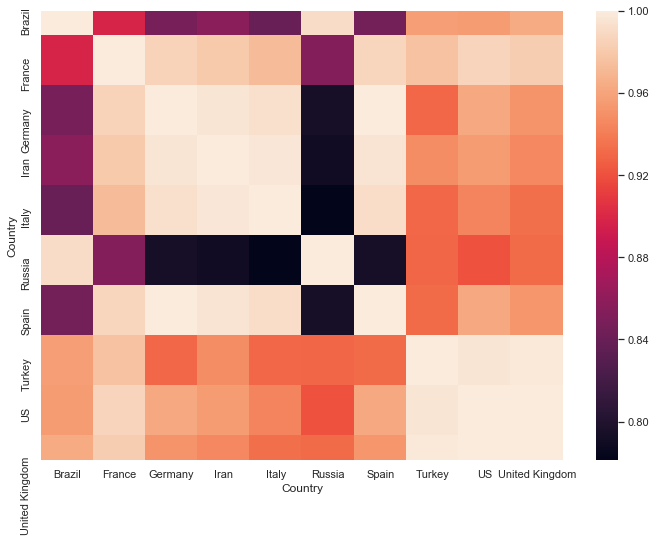

In [73]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
corr_confirmed = alls_c.corr()
sns.heatmap(corr_confirmed, 
        xticklabels=corr_confirmed.columns,
        yticklabels=corr_confirmed.columns)

In [74]:
top10_d = df_countrydate3[df_countrydate3["Country"].isin(list(top10_deaths["Country"]))]
alls_d = pd.pivot_table(top10_d, values = "Deaths", columns = "Country", index = "Date")
alls_d.head()

Country     Belgium  Brazil  France  Germany  Iran  Italy  Netherlands  Spain  \
Date                                                                            
2020-01-22      nan     nan     nan      nan   nan    nan          nan    nan   
2020-01-23      nan     nan     nan      nan   nan    nan          nan    nan   
2020-01-24      nan     nan    0.00      nan   nan    nan          nan    nan   
2020-01-25      nan     nan    0.00      nan   nan    nan          nan    nan   
2020-01-26      nan     nan    0.00      nan   nan    nan          nan    nan   

Country      US  United Kingdom  
Date                             
2020-01-22 0.00             nan  
2020-01-23 0.00             nan  
2020-01-24 0.00             nan  
2020-01-25 0.00             nan  
2020-01-26 0.00             nan

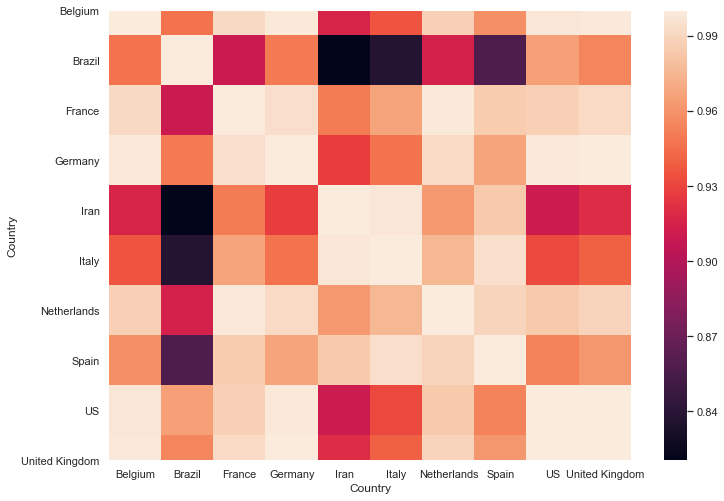

In [75]:
corr_deaths = alls_d.corr()
sns.heatmap(corr_deaths, 
        xticklabels=corr_deaths.columns,
        yticklabels=corr_deaths.columns)

In [76]:
top10_r = df_countrydate3[df_countrydate3["Country"].isin(list(top10_recovered["Country"]))]
alls_r = pd.pivot_table(top10_r, values = "Recovered", columns = "Country", index = "Date")
alls_r.head()

Country     Brazil  China  France  Germany  Iran  Italy  Spain  Switzerland  \
Date                                                                          
2020-01-22     nan  28.00     nan      nan   nan    nan    nan          nan   
2020-01-23     nan  30.00     nan      nan   nan    nan    nan          nan   
2020-01-24     nan  36.00    0.00      nan   nan    nan    nan          nan   
2020-01-25     nan  39.00    0.00      nan   nan    nan    nan          nan   
2020-01-26     nan  49.00    0.00      nan   nan    nan    nan          nan   

Country     Turkey   US  
Date                     
2020-01-22     nan 0.00  
2020-01-23     nan 0.00  
2020-01-24     nan 0.00  
2020-01-25     nan 0.00  
2020-01-26     nan 0.00

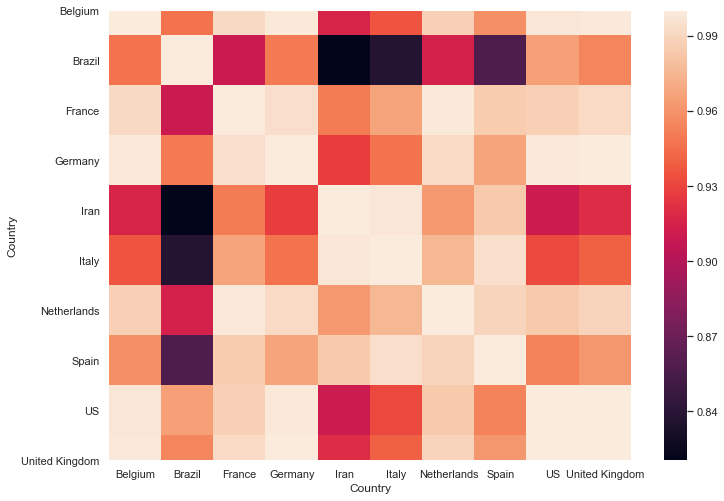

In [77]:
corr_recovered = alls_d.corr()
sns.heatmap(corr_recovered, 
        xticklabels=corr_recovered.columns,
        yticklabels=corr_recovered.columns)

Можно заметить, что корреляция между всеми целевыми показателями стран высокая, их динамика схоже, что мы также наблюдали в предыдущих пунктах.

In [81]:
fig = px.line(top10_c, x="days_since_frst", y="Confirmed", color="Country")

fig.update_layout(
    title="COVID-19: top-10 trend (days since first confirmed case)",
    xaxis_title="Days since first confirmed case",
    yaxis_title="Confirmed cases",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

In [79]:
top10_r = df_countrydate3[df_countrydate3["Country"].isin(list(top10_recovered["Country"]))][["Date", "Country", "Recovered", "days_since_frst"]]
top10_r

Date Country  Recovered  days_since_frst
0     2020-01-22   China      28.00                0
1     2020-01-23   China      30.00                1
2     2020-01-24   China      36.00                2
3     2020-01-25   China      39.00                3
4     2020-01-26   China      49.00                4
...          ...     ...        ...              ...
7877  2020-04-28  Turkey   38809.00               48
7878  2020-04-29  Turkey   44040.00               49
7879  2020-04-30  Turkey   48886.00               50
7880  2020-05-01  Turkey   53808.00               51
7881  2020-05-02  Turkey   58259.00               52

[848 rows x 4 columns]

In [80]:
fig = px.line(top10_r, x="days_since_frst", y="Recovered", color="Country")

fig.update_layout(
    title="COVID-19: top-10 trend (days since first confirmed case)",
    xaxis_title="Days since first confirmed case",
    yaxis_title="Recovered",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

In [82]:
top10_d = df_countrydate3[df_countrydate3["Country"].isin(list(top10_confirmed["Country"]))][["Date", "Country", "Deaths", "days_since_frst"]]
top10_d

Date Country  Deaths  days_since_frst
510   2020-01-22      US    0.00                0
511   2020-01-23      US    0.00                1
512   2020-01-24      US    0.00                2
513   2020-01-25      US    0.00                3
514   2020-01-26      US    0.00                4
...          ...     ...     ...              ...
7877  2020-04-28  Turkey 2992.00               48
7878  2020-04-29  Turkey 3081.00               49
7879  2020-04-30  Turkey 3174.00               50
7880  2020-05-01  Turkey 3258.00               51
7881  2020-05-02  Turkey 3336.00               52

[864 rows x 4 columns]

In [83]:
fig = px.line(top10_d, x="days_since_frst", y="Deaths", color="Country")

fig.update_layout(
    title="COVID-19: top-10 trend (days since first confirmed case)",
    xaxis_title="Date",
    yaxis_title="Death",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

In [ ]:
# Можно заметить, что во всех странах вирус распространяется по схожему паттерну, корреляция между целевыми 
# признаками для всех стран высокая. 

1.7 **Для первых 5 стран из топ-10 и России постойте сравнительные графики. Изучите как изменялись значения отношений погибших/выздоровивших, погибших/заболевших, заболевших/общее число жителей, ваш вариант...**

In [84]:
population = pd.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")
population = population.rename(columns = {"Country Name":"Country"})
population = population.rename(columns = {"Value":"Population"})
population.Country[population["Country"] == "United States"] = "US"
population.Country[population["Country"] == "Russian Federation"] = "Russia"
population = population[population["Year"] == 2018]
df_countrydate17 = df_countrydate3.merge(population, how = "left")
df_countrydate17.head()

Date Country     Lat    Long  Confirmed  Recovered  Deaths  \
0  2020-01-22   China  743.86 2723.06     548.00      28.00   17.00   
1  2020-01-23   China  971.81 3386.39     643.00      30.00   18.00   
2  2020-01-24   China 1015.90 3500.33     920.00      36.00   26.00   
3  2020-01-25   China 1051.64 3596.33    1406.00      39.00   42.00   
4  2020-01-26   China 1051.64 3596.33    2075.00      49.00   56.00   

   mortality_rate   Frst_case  days_since_frst  Confirmed_log Country Code  \
0            3.10  2020-01-22                0           6.31          CHN   
1            2.80  2020-01-22                1           6.47          CHN   
2            2.83  2020-01-22                2           6.82          CHN   
3            2.99  2020-01-22                3           7.25          CHN   
4            2.70  2020-01-22                4           7.64          CHN   

     Year    Population  
0 2018.00 1392730000.00  
1 2018.00 1392730000.00  
2 2018.00 1392730000.00  
3 2018.00 1392730000.00  
4 2018.00 1392730000.00

In [85]:
# Рассмотрим топ-10 стран с подтвержденными случаями 
c_search = list(top10_confirmed[:5]["Country"]) + ["Russia"]
c_17 = df_countrydate17[df_countrydate17["Country"].isin(c_search)]
c_17["D_vs_R"] = (c_17["Deaths"]/c_17["Recovered"])*100
c_17["D_vs_C"] = (c_17["Deaths"]/c_17["Confirmed"])*100
c_17["C_vs_Pop"] = (c_17["Confirmed"]/c_17["Population"])*100
c_17["D_vs_Pop"] = (c_17["Deaths"]/c_17["Population"])*100
c_17.head()

Date Country   Lat   Long  Confirmed  Recovered  Deaths  \
510  2020-01-22      US 37.09 -95.71       1.00       0.00    0.00   
511  2020-01-23      US 37.09 -95.71       1.00       0.00    0.00   
512  2020-01-24      US 37.09 -95.71       2.00       0.00    0.00   
513  2020-01-25      US 37.09 -95.71       2.00       0.00    0.00   
514  2020-01-26      US 37.09 -95.71       5.00       0.00    0.00   

     mortality_rate   Frst_case  days_since_frst  Confirmed_log Country Code  \
510            0.00  2020-01-22                0           0.00          USA   
511            0.00  2020-01-22                1           0.00          USA   
512            0.00  2020-01-22                2           0.69          USA   
513            0.00  2020-01-22                3           0.69          USA   
514            0.00  2020-01-22                4           1.61          USA   

       Year   Population  D_vs_R  D_vs_C  C_vs_Pop  D_vs_Pop  
510 2018.00 326687501.00     nan    0.00      0.00      0.00  
511 2018.00 326687501.00     nan    0.00      0.00      0.00  
512 2018.00 326687501.00     nan    0.00      0.00      0.00  
513 2018.00 326687501.00     nan    0.00      0.00      0.00  
514 2018.00 326687501.00     nan    0.00      0.00      0.00

In [86]:
c_17["Country"].unique()

array(['US', 'France', 'Italy', 'Russia', 'United Kingdom', 'Spain'],
      dtype=object)

In [87]:
# Погибшие vs Вызоровившие 
fig = px.line(c_17, x="days_since_frst", y="D_vs_R", color="Country")

fig.update_layout(
    title="COVID-19: top-5 + Russia",
    xaxis_title="Date",
    yaxis_title="Dead vs Recovered",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

In [88]:
# Погибшие vs Заболевшие
fig = px.line(c_17, x="days_since_frst", y="D_vs_C", color="Country")

fig.update_layout(
    title="COVID-19: top-5 + Russia",
    xaxis_title="Date",
    yaxis_title="Dead vs Confirmed",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

# Можем отметить, как количество смертей по отношению к подтвержденным случаям сначало резко возросло, потом 
# резко снизилось, и далее опять продолжило рост. Это характерно для всех стран из ТОП-5, кроме Великобритании, 
# где не произошло резкого падения, скорее всего из-за позднего введения локдауна.

In [89]:
# Заболевшие vs число жителей 

fig = px.line(c_17, x="days_since_frst", y="C_vs_Pop", color="Country")

fig.update_layout(
    title="COVID-19: top-5 + Russia",
    xaxis_title="Date",
    yaxis_title="Confirmed cases vs Population value",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

In [90]:
# Погибшие vs Число жителей

fig = px.line(c_17, x="days_since_frst", y="D_vs_Pop", color="Country")

fig.update_layout(
    title="COVID-19: top-5 + Russia",
    xaxis_title="Date",
    yaxis_title="Dead vs Population value",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

In [ ]:
# Выводы: распространение вируса во всех странах следуюет схожему паттерну. 

1.8 **Выделите временной ряд по одному из целевых признаков**. Для выделенного временного ряда:
  - Представьте временной ряд в виде последовательности разницы между значениями. Рассчитайте лаги, выведите их на графике.
  - Попробуйте декомпозировать временной ряд. Постройте график тренда.
  - Что вы можете сказать о стационарности временного ряда?

**Выделим временной ряд для Турции по числу зараженных.** 

In [485]:
turkey_series = df_countrydate17[df_countrydate17["Country"] == "Turkey"]
turkey_series.head()

Date Country   Lat  Long  Confirmed  Recovered  Deaths  \
7829  2020-03-11  Turkey 38.96 35.24       1.00       0.00    0.00   
7830  2020-03-12  Turkey 38.96 35.24       1.00       0.00    0.00   
7831  2020-03-13  Turkey 38.96 35.24       5.00       0.00    0.00   
7832  2020-03-14  Turkey 38.96 35.24       5.00       0.00    0.00   
7833  2020-03-15  Turkey 38.96 35.24       6.00       0.00    0.00   

      mortality_rate   Frst_case  days_since_frst  Confirmed_log Country Code  \
7829            0.00  2020-03-11                0           0.00          TUR   
7830            0.00  2020-03-11                1           0.00          TUR   
7831            0.00  2020-03-11                2           1.61          TUR   
7832            0.00  2020-03-11                3           1.61          TUR   
7833            0.00  2020-03-11                4           1.79          TUR   

        Year  Population  
7829 2018.00 82319724.00  
7830 2018.00 82319724.00  
7831 2018.00 82319724.00  
7832 2018.00 82319724.00  
7833 2018.00 82319724.00

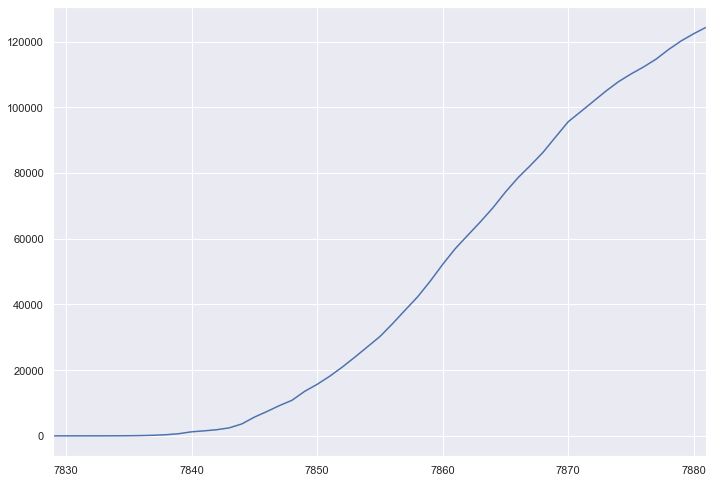

In [487]:
turkey_series.Confirmed.plot();

**Дифференцирование - расчет разницы с определенным временным лагом.** Т.е. это переход от ряда $X_{t}$ к ряду разностей $X_{t} - X_{t-l}$

In [488]:
# Рассчитаем лаги,  
turkey_series["Confirmed_Shift"] = turkey_series.Confirmed.shift(periods = 1)
turkey_series = turkey_series.set_index("Date")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


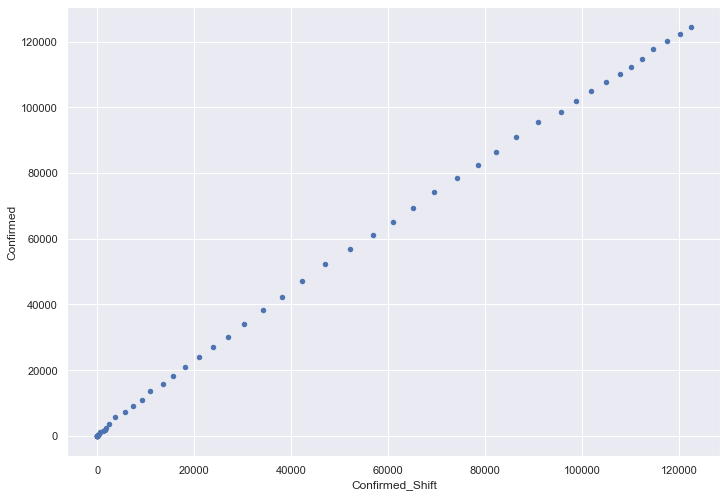

In [471]:
# Выведем на графике Confirmed и Confirmed_Shift
turkey_series.plot(kind= "scatter", y = "Confirmed", x = "Confirmed_Shift")

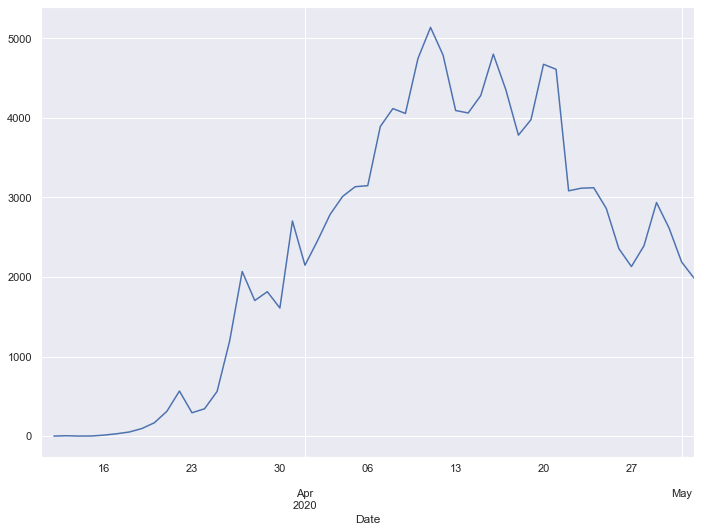

In [497]:
turkey_series["Confirmed_diff"] = turkey_series["Confirmed"] - turkey_series["Confirmed_Shift"]
turkey_series.Confirmed_diff.plot();

In [481]:
import statsmodels.api as sm
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(turkey_series.Confirmed_diff[1:])[1])
# Ряд нестационарен

Критерий Дики-Фуллера: p=0.319449


**Декомпозиция - моделирование как тренда, так и сезонности и удаление их из модели.**

In [489]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [494]:
turkey_series = turkey_series.reset_index()
turkey_series["Date"] = pd.to_datetime(turkey_series["Date"])
turkey_series = turkey_series.set_index("Date")

In [498]:
decomposition = seasonal_decompose(turkey_series.Confirmed_diff[1:].dropna(), model = "additive")

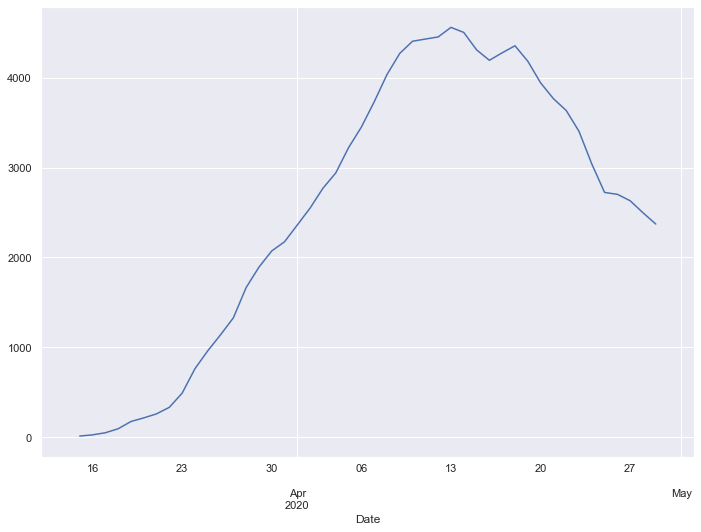

In [499]:
decomposition.trend.plot()

**Проверка на стационароность** 

Под стационарностью понимается свойство процесса не менять своих статистических характеристик с течением времени, т.е: 
* постоянство матожидания и дисперсии; 
* независимость ковариационной функции от времени (зависимость только от расстояния между наблюдениями) 

По визуализации нашего ряда понятно, что ряд нестационарен (виден тренд, разная вариация), однако дополнительно используем критерий Дики-Фуллера: 

In [500]:
import statsmodels.api as sm
test = sm.tsa.adfuller(turkey_series.Confirmed)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -2.922669580866902
p-value:  0.0427746298951792
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Есть единичные корни, ряд не стационарен


1.9 **Для любого интересующего Вас временного ряда постройте графики ACF и PACF. Сделайте выводы.** 

В этх графиках по оси X откладываются номера лагов, а по оси Y -- значения соответствующих функций, ACF или PACF. Эти графики помогают определить компоненты p и q. ACF показывает значение автокорреляции любого ряда с его лагированными значениями. По сути ACF графи описывает насколько хорошо значение ряда соотносится с его предыдущим значением. В PACF находится значение корреляции остатков со следующим лагированным значением. То есть если есть некоторая скрытая информация в остатках, которая может быть смоделирована следующим лагом, мы получим значение высокой корреляции. 

In [501]:
from statsmodels.tsa.stattools import acf, pacf

In [502]:
ts = turkey_series.Confirmed
ts_diff = turkey_series.Confirmed_diff
ts_diff.dropna(inplace = True)

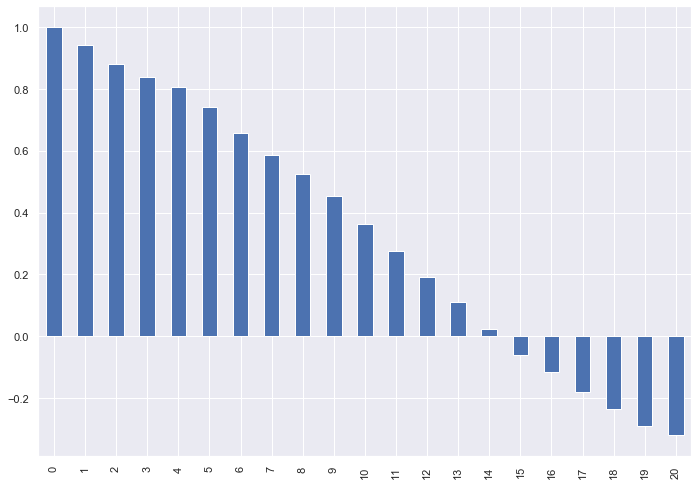

In [503]:
# ACF
lag_acf = acf(ts_diff, nlags=20)
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar")

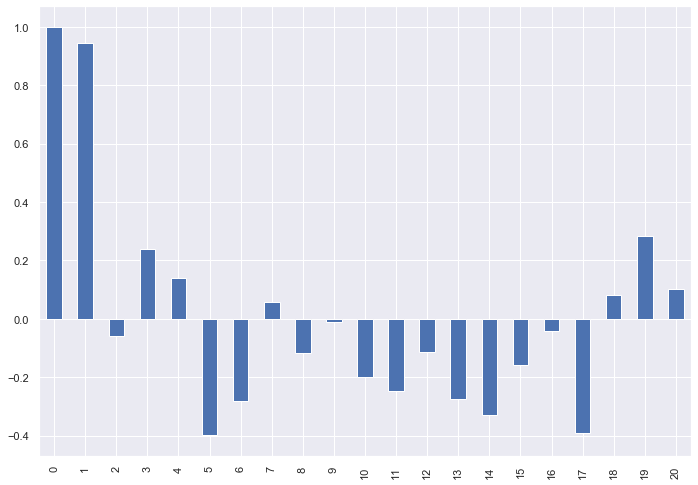

In [504]:
# PACF
lag_pacf = pacf(ts_diff, nlags=20, method='ols')
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar")

На предыдущем графике не отображен доверительный интервал, поэтому воспользуемся следующим: 

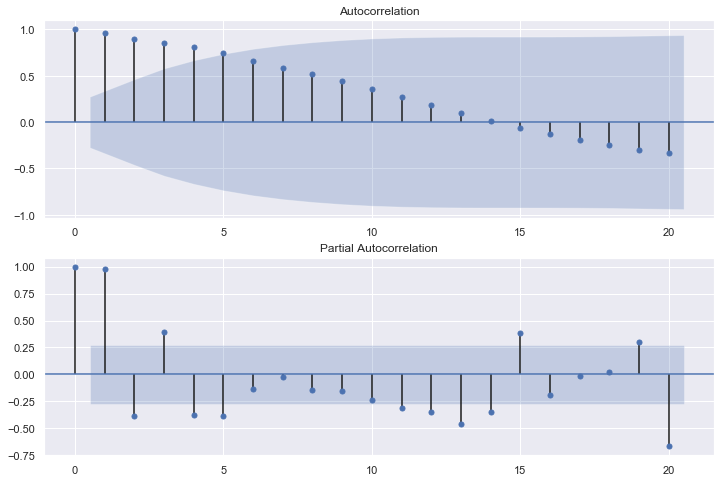

In [179]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff.values.squeeze(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff, lags=20, ax=ax2)

**Вывод**: По коррелограмме ACF можно сделать вывод, что q = 5, так как после этого значения функции резко падают и пересекают доверительный интервал. То есть максимальный номер коэффициента сильно отличный от 0 в модели AR -- 5. По коррелограмме PACF можно сделать вывод, что p = 2, так как это наибольший значимый лаг, после которого лаги
становятся незначимы. То есть количество количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA -- 2. 

#### 1.10. Изучаемый Вами датасет отражает текущую мировую статистику распространения болезни. Однако эти данные не дают нам возможноси предположить о возможных факторах, которые влюяют на скорость распространения, летальности, заразность и тд. Поэтому в наш датасет можно добавить новые признаки из других наборов данных, которые могут не только помочь при прогнозировании временного ряда, но и определить наиболее значимые факторы.

- Добавьте новый признак "количество дней со дня первого случая заражения". Добавьте еще не менее 5 новых признаков в датасет, которые могут быть значимым фактором распространения вируса. Сохраните полученный датасет, вы можете его использовать во второй части домашнего задания.
- Исследуйте как добавленные признаки соотносятся с трендами распространения короновируса в некоторых странах. Сделайте выводы.

*Примеры признаков - количество дней со начала карантина, конинент, плотность населения, количество употребляемого алкоголя, летучих мышей, алкоголя, крокодилов на душу населения, количество туристов в год, уровень безработицы, температура, количество игроков в Plague Inc., средний возраст или продолжительность жизни и так далее. Вы можете использовать любой найденный датасет. Главное, чтобы у Вас получилось скомбинировать данные.*

  Примеры датасеты:
  1. [500 Cities: Local Data for Better Health (2019)](https://www.kaggle.com/jaimeblasco/500-cities-local-data-for-better-health-2019)
  2. [Daily global surface summary from over 9000 weather stations from 1929 to now](https://www.kaggle.com/noaa/gsod)
  3. [Population by Country - 2020](https://www.kaggle.com/tanuprabhu/population-by-country-2020)



In [214]:
new_df = df_countrydate17.merge(regions, how = "left")

В предыдущих заданиях в датасет уже были добавлены признаки *количество дней со дня первого случая заражения*, *регион* и *население*. Добавим также: 
* [Life Expectancy](https://www.kaggle.com/amansaxena/lifeexpectancy#Life_expectancy_dataset.csv)
* [GDP](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD)
* [Unemployment](https://data.worldbank.org/indicator/SL.UEM.TOTL.ZS)
* [Political Regime: Polity IV](https://github.com/owid/owid-datasets/blob/master/datasets/Polity%20IV%20Index/Polity%20IV%20Index.csv)

In [550]:
gdp = pd.read_csv("https://raw.githubusercontent.com/datasets/gdp/master/data/gdp.csv")
life = pd.read_csv("Life_expectancy_dataset.csv", encoding='latin-1')
unemployment = pd.read_csv("https://gist.githubusercontent.com/bpartopour/ac59e1a57da1235f19cd47b1791f3673/raw/bf210a8abc847b1c8d12f99f0bf6ff811f7d4937/unemployment.csv")
polity4 = pd.read_csv("https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/Polity%20IV%20Index/Polity%20IV%20Index.csv")

In [551]:
polity4 = polity4[polity4["Year"] == 2011]
polity4 = polity4.rename(columns = {"Polity IV Index":"Polity"})
polity4["Polity"] = [int(i) for i in polity4["Polity"]]

In [552]:
polity4["Polity"].describe()

count   155.00
mean      4.19
std       6.25
min     -10.00
25%      -1.50
50%       7.00
75%       9.00
max      10.00
Name: Polity, dtype: float64

In [553]:
polity4["Polity2"] = "Nan"
polity4.loc[polity4["Polity"] == 10, "Polity2"] = "Full_Dem"
polity4.loc[(polity4["Polity"] >= 6) & (polity4["Polity"] <= 9), "Polity2"] = "Dem"
polity4.loc[(polity4["Polity"] >= 1) & (polity4["Polity"] <= 5), "Polity2"] = "Open_An"
polity4.loc[(polity4["Polity"] >= -5) & (polity4["Polity"] <= 0), "Polity2"] = "Closed_An"
polity4.loc[(polity4["Polity"] >= -10) & (polity4["Polity"] <= -6), "Polity2"] = "Autoc"
polity4.head()

Entity  Year  Polity    Polity2
276    Albania  2011       9        Dem
326    Algeria  2011       2    Open_An
362     Angola  2011      -2  Closed_An
549  Argentina  2011       8        Dem
637    Armenia  2011       5    Open_An

In [554]:
polity4 = polity4.rename(columns = {"Entity":"Country"})

In [567]:
gdp_filt = gdp[gdp["Year"] == 2016][["Country Name", "Value"]]
gdp_filt = gdp_filt.rename(columns={'Country Name':'Country'})
gdp_filt = gdp_filt.rename(columns={'Value':'GDP'})
life_filt = life[["Country", "Overall Life"]]
unemployment_filt = unemployment[["Country", "2019"]]
unemployment_filt = unemployment_filt.rename(columns = {"2019":"Unemployment"})

gdp_life = gdp_filt.merge(life_filt, on = "Country", how = "outer")
gdp_life_un = gdp_life.merge(unemployment_filt, on = "Country", how = "outer")
new_df2 = new_df.merge(gdp_life_un, on = "Country", how = "left")
new_df3 = new_df2.merge(polity4, on = "Country", how = "left")
new_df3.head()

Date Country     Lat    Long  Confirmed  Recovered  Deaths  \
0  2020-01-22   China  743.86 2723.06     548.00      28.00   17.00   
1  2020-01-23   China  971.81 3386.39     643.00      30.00   18.00   
2  2020-01-24   China 1015.90 3500.33     920.00      36.00   26.00   
3  2020-01-25   China 1051.64 3596.33    1406.00      39.00   42.00   
4  2020-01-26   China 1051.64 3596.33    2075.00      49.00   56.00   

   mortality_rate   Frst_case  days_since_frst  ...  Country Code  Year_x  \
0            3.10  2020-01-22                0  ...           CHN 2018.00   
1            2.80  2020-01-22                1  ...           CHN 2018.00   
2            2.83  2020-01-22                2  ...           CHN 2018.00   
3            2.99  2020-01-22                3  ...           CHN 2018.00   
4            2.70  2020-01-22                4  ...           CHN 2018.00   

     Population  region               GDP  Overall Life  Unemployment  Year_y  \
0 1392730000.00    Asia 11199145157649.20           nan          4.02 2011.00   
1 1392730000.00    Asia 11199145157649.20           nan          4.02 2011.00   
2 1392730000.00    Asia 11199145157649.20           nan          4.02 2011.00   
3 1392730000.00    Asia 11199145157649.20           nan          4.02 2011.00   
4 1392730000.00    Asia 11199145157649.20           nan          4.02 2011.00   

   Polity  Polity2  
0   -7.00    Autoc  
1   -7.00    Autoc  
2   -7.00    Autoc  
3   -7.00    Autoc  
4   -7.00    Autoc  

[5 rows x 21 columns]

In [562]:
# Агрегируем показатели по политическому режиму 
confirmed_regime = new_df3.groupby(["Date", "Polity2"]).sum()
confirmed_regime = confirmed_regime.reset_index()

In [564]:
fig = px.line(confirmed_regime, x="Date", y="Confirmed", color="Polity2")

fig.update_layout(
    title="COVID-19: confirmed cases by political regime",
    xaxis_title="Date",
    yaxis_title="Dead vs Population value",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

# Можем наблюдать, что в демократиях и полных демократиях больше выявленных случаев, что может быть связано с 
# большей транспарентностью и более открытым подходом к данным.

In [566]:
fig = px.line(confirmed_regime, x="Date", y="Deaths", color="Polity2")

fig.update_layout(
    title="COVID-19: death cases by political regime",
    xaxis_title="Date",
    yaxis_title="Dead vs Population value",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.show()

# Такая же картина (больше случаев в демократиях по сравнению с не-демократиями), что может быть связано с низкой 
# транспарентностью режимов. 

Так как взаимосвязь тренда 

### 1.11 Выводы
<здесь место для ваших выводов>

## 2. Прогнозирование временного ряда

Теперь вам предстоит построить несколько моделей и спрогнозировать временной ряд для такого показателя как летальности от вируса. Летальность можно рассчитывать по формуле:

$$ CFR = \frac{Deaths}{Confirmed} $$

Для каждого типа модели сделайте несколько прогнозов для не менее 3 разных стран/регионов/другое (на ваш обоснованный выбор). Главное, чтобы каждый из типов моделей прознозировал одинаковый набор данных, чтобы в конце можно было сделать выводы о качестве работы той или иной модели.

Метрика качества RMSE. Не забудьте разбить данные временной ряд на данные для обучения и тестовые.

Не забывайте сопровождать ваш код комментариями, графиками и выводами.

Выберем три страны: 
* Турция 
* Италия 
* Германия 

In [1526]:
new_df3["Date"] = pd.to_datetime(new_df3["Date"])
new_df3 = new_df3.rename(columns = {"Overall Life":"Life"})

In [1527]:
turkey = new_df3[(new_df3["Country"] == "Turkey") & (new_df3["Confirmed"] > 0)]
italy = new_df3[(new_df3["Country"] == "Italy") & (new_df3["Confirmed"] > 0)]
germany = new_df3[(new_df3["Country"] == "Germany") & (new_df3["Confirmed"] > 0)]

turkey["CFR"] = turkey["Deaths"]/turkey["Confirmed"]
italy["CFR"] = italy["Deaths"]/italy["Confirmed"]
germany["CFR"] = germany["Deaths"]/germany["Confirmed"]

turkey = turkey[turkey["CFR"] > 0]
italy = italy[italy["CFR"] > 0]
germany = germany[germany["CFR"] > 0]

In [1528]:
# turkey = usa.set_index("Date")
# italy = italy.set_index("Date")
# germany = germany.set_index("Date")

In [1529]:
turkey["CFR_Shift"] = turkey.CFR.shift(periods = 1)
turkey["CFR_diff"] = turkey["CFR"] - turkey["CFR_Shift"]
italy["CFR_Shift"] = italy.CFR.shift(periods = 1)
italy["CFR_diff"] = italy["CFR"] - italy["CFR_Shift"]
germany["CFR_Shift"] = germany.CFR.shift(periods = 1)
germany["CFR_diff"] = germany["CFR"] - germany["CFR_Shift"]

In [1530]:
turkey = turkey.reset_index()
italy = italy.reset_index()
germany = germany.reset_index()

In [1531]:
# Еще раз повторим ... 
turkey["timeIndex"] = turkey.Date - turkey.Date.min()
italy["timeIndex"] = italy.Date - italy.Date.min()
germany["timeIndex"] = germany.Date - germany.Date.min()

In [1532]:
turkey["timeIndex"] = turkey["timeIndex"]/ np.timedelta64(1, 'D')
italy["timeIndex"] = italy["timeIndex"]/ np.timedelta64(1, 'D')
germany["timeIndex"] = germany["timeIndex"]/ np.timedelta64(1, 'D')

In [1533]:
# Разобьем данные на трейн и тест 
train_set_t, test_set_t = np.split(turkey, [int(.8 *len(turkey))])
train_set_r, test_set_r = np.split(italy, [int(.8 *len(italy))])
train_set_g, test_set_g = np.split(germany, [int(.8 *len(germany))])

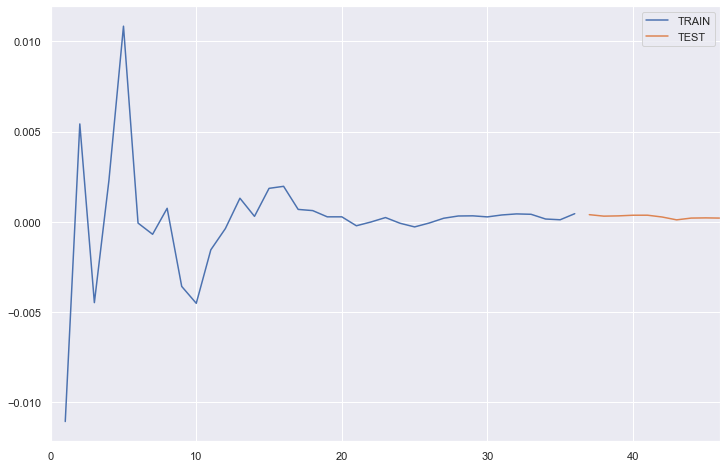

In [1534]:
train_set_t['CFR_diff'].plot(legend=True,label='TRAIN')
test_set_t['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8));

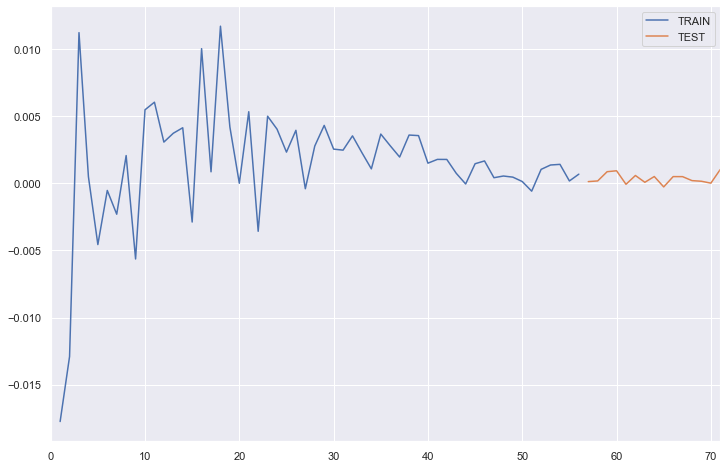

In [1535]:
train_set_r['CFR_diff'].plot(legend=True,label='TRAIN')
test_set_r['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8));

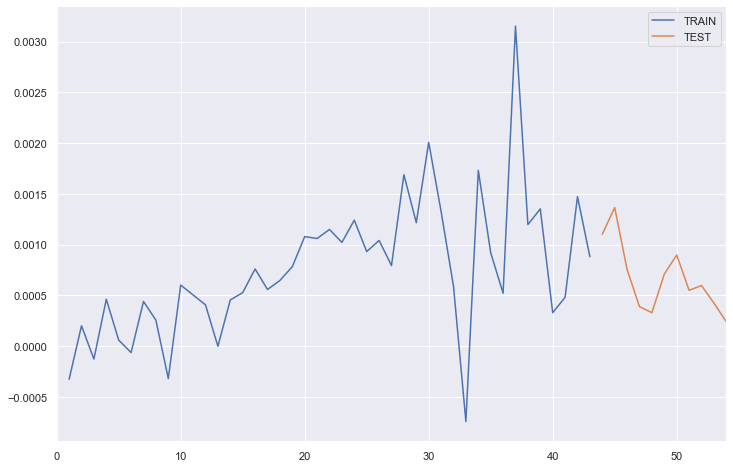

In [1536]:
train_set_g['CFR_diff'].plot(legend=True,label='TRAIN')
test_set_g['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8));

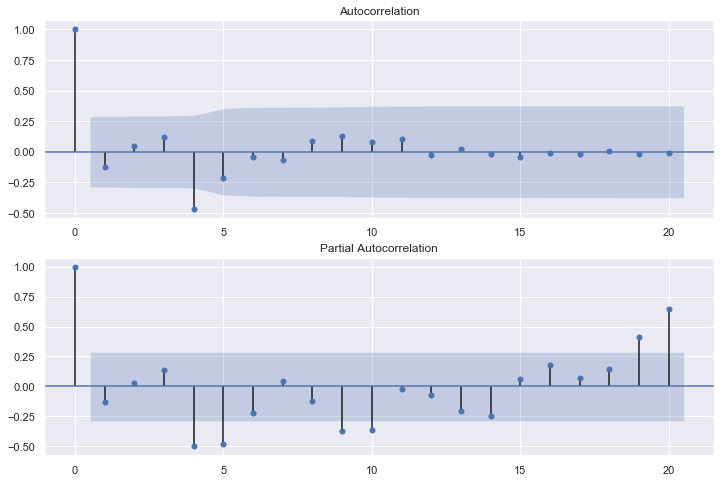

In [1537]:
ts = turkey.CFR
ts_diff = turkey.CFR_diff
ts_diff.dropna(inplace = True)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff.values.squeeze(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff, lags=20, ax=ax2)

# ACF => q = 4 
# PACF => p = 1

In [1412]:
test = sm.tsa.adfuller(turkey.CFR_diff)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -11.354422423449178
p-value:  9.814116366540333e-21
Critical values:  {'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}
Единичных корней нет, ряд стационарен


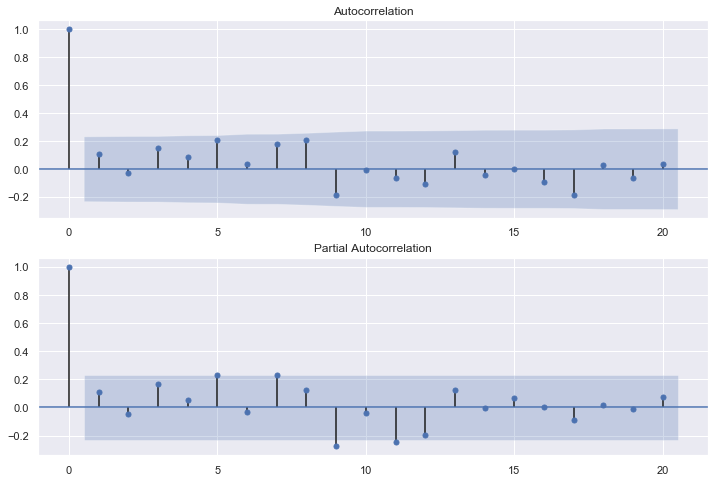

In [1413]:
ts = italy.CFR
ts_diff = italy.CFR_diff
ts_diff.dropna(inplace = True)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff.values.squeeze(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff, lags=20, ax=ax2)

# ACF => q = 1 
# PACF => p = 1 / 9 

In [1401]:
test = sm.tsa.adfuller(italy.CFR_diff)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')
    
# Здесь дифференцирование не сработало :(

adf:  -1.9537526779803278
p-value:  0.3072115534618201
Critical values:  {'1%': -3.5656240522121956, '5%': -2.920142229157715, '10%': -2.598014675124952}
Есть единичные корни, ряд не стационарен


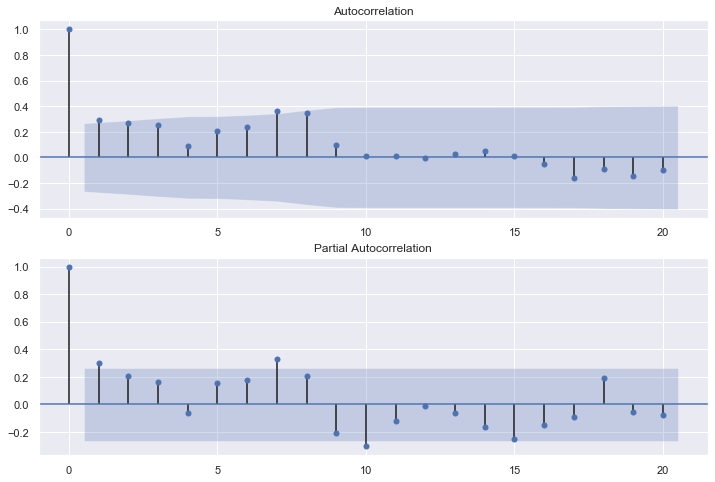

In [1414]:
ts = germany.CFR
ts_diff = germany.CFR_diff
ts_diff.dropna(inplace = True)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff.values.squeeze(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff, lags=20, ax=ax2)

# ACF => q = 1 
# PACF => p = 1 / 7

In [1415]:
test = sm.tsa.adfuller(germany.CFR_diff)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -5.379600795417166
p-value:  3.73789494211734e-06
Critical values:  {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}
Единичных корней нет, ряд стационарен


In [1416]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [1417]:
modelResults_t = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])
modelResults_r = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])
modelResults_g = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])


modelResults_t.head()

Empty DataFrame
Columns: [Model, Forecast, RMSE]
Index: []

### 2.1 Прогнозирование средним (Mean Constant Model)

Будем считать, что прогнозируемый период будет соответствовать среднему предешествовавих периодов.

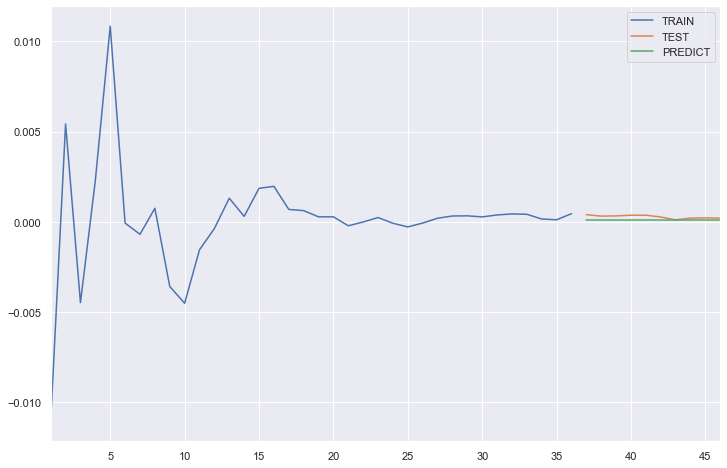

In [1418]:
model_mean_pred_t = train_set_t.CFR_diff[1:].mean()
test_set_t["CFRMean"] = model_mean_pred_t
train_set_t['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_t['CFR_diff'].plot(legend=True,label='TEST')
test_set_t["CFRMean"].plot(legend=True,label='PREDICT',figsize=(12,8));

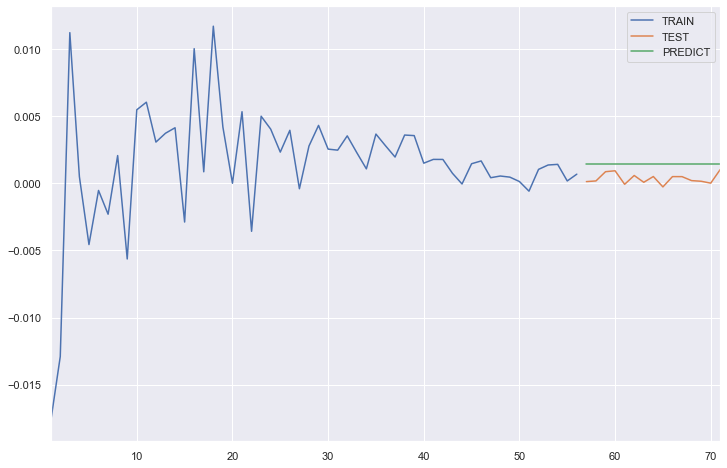

In [1419]:
model_mean_pred_r = train_set_r.CFR_diff[1:].mean()
test_set_r["CFRMean"] = model_mean_pred_r
train_set_r['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_r['CFR_diff'].plot(legend=True,label='TEST')
test_set_r["CFRMean"].plot(legend=True,label='PREDICT',figsize=(12,8));

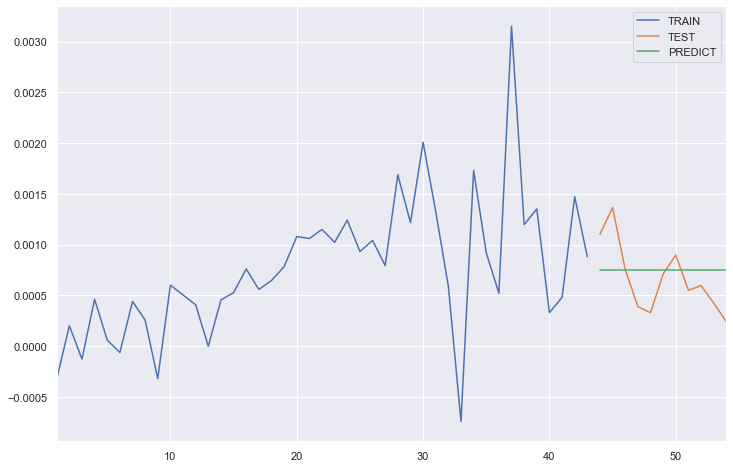

In [1420]:
model_mean_pred_g = train_set_g.CFR_diff[1:].mean()
test_set_g["CFRMean"] = model_mean_pred_g
train_set_g['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_g['CFR_diff'].plot(legend=True,label='TEST')
test_set_g["CFRMean"].plot(legend=True,label='PREDICT',figsize=(12,8));

In [1421]:
model_mean_RMSE_t = RMSE(test_set_t.CFRMean, test_set_t.CFR_diff)
model_mean_RMSE_r = RMSE(test_set_r.CFRMean, test_set_r.CFR_diff)
model_mean_RMSE_g = RMSE(test_set_g.CFRMean, test_set_g.CFR_diff)

In [1422]:
modelResults_t.loc[0,"Model"] = "Mean"
modelResults_t.loc[0,"Forecast"] = model_mean_pred_t
modelResults_t.loc[0,"RMSE"] = model_mean_RMSE_t
modelResults_t.head()

Model Forecast RMSE
0  Mean     0.00 0.00

In [1423]:
modelResults_r.loc[0,"Model"] = "Mean"
modelResults_r.loc[0,"Forecast"] = model_mean_pred_r
modelResults_r.loc[0,"RMSE"] = model_mean_RMSE_r
modelResults_r.head()

Model Forecast RMSE
0  Mean     0.00 0.00

In [1424]:
modelResults_g.loc[0,"Model"] = "Mean"
modelResults_g.loc[0,"Forecast"] = model_mean_pred_g
modelResults_g.loc[0,"RMSE"] = model_mean_RMSE_g
modelResults_g.head()

Model Forecast RMSE
0  Mean     0.00 0.00

#### 2.2 Линейная модель (Linear Trend Model) 

Построим линейную зависимость между CFR и количеством дней с первого заболевания. 

In [1425]:
import statsmodels.formula.api as smf

Intercept   -0.00
timeIndex    0.00
dtype: float64


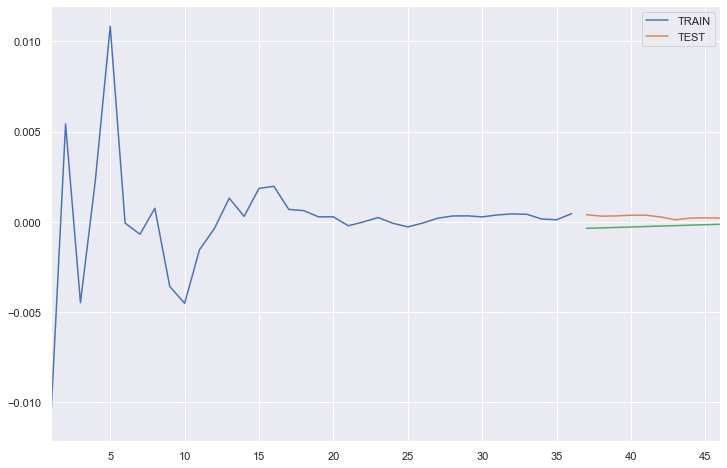

In [1429]:
model_linear_t = smf.ols('CFR_diff ~ timeIndex', data = train_set_t[1:]).fit()
model_linear_pred_t = model_linear_t.predict()[:len(test_set_t)]
print(model_linear_t.params)

train_set_t['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_t['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
plt.plot(test_set_t.timeIndex,model_linear_pred_t, '-')

Intercept   0.00
timeIndex   0.00
dtype: float64


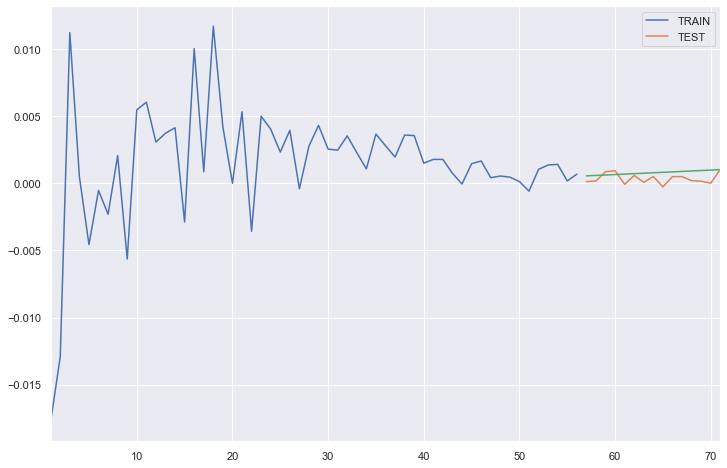

In [1430]:
model_linear_r = smf.ols('CFR_diff ~ timeIndex', data = train_set_r).fit()
model_linear_pred_r = model_linear_r.predict()[:len(test_set_r)]
print(model_linear_r.params)

train_set_r['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_r['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
plt.plot(test_set_r.timeIndex,model_linear_pred_r, '-')

Intercept   0.00
timeIndex   0.00
dtype: float64


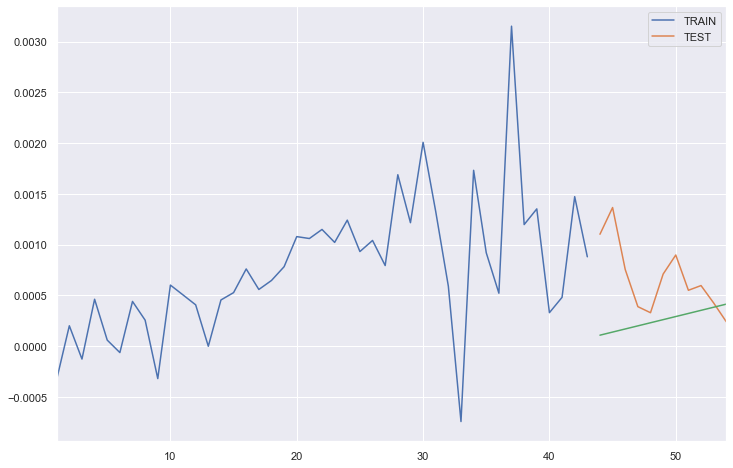

In [1431]:
model_linear_g = smf.ols('CFR_diff ~ timeIndex', data = train_set_g).fit()
model_linear_pred_g = model_linear_g.predict()[:len(test_set_g)]
print(model_linear_g.params)

train_set_g['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_g['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
plt.plot(test_set_g.timeIndex,model_linear_pred_g, '-')

In [1432]:
model_linear_RMSE_t = RMSE(model_linear_pred_t, test_set_t.CFR_diff)
model_linear_RMSE_r = RMSE(model_linear_pred_r, test_set_r.CFR_diff)
model_linear_RMSE_g = RMSE(model_linear_pred_g, test_set_g.CFR_diff)

In [1433]:
modelResults_t.loc[1,"Model"] = "Linear"
modelResults_t.loc[1,"Forecast"] = "Linear"
modelResults_t.loc[1,"RMSE"] = model_mean_RMSE_t
modelResults_t.head()

Model Forecast RMSE
0    Mean     0.00 0.00
1  Linear   Linear 0.00

In [1434]:
modelResults_r.loc[1,"Model"] = "Linear"
modelResults_r.loc[1,"Forecast"] = "Linear"
modelResults_r.loc[1,"RMSE"] = model_mean_RMSE_r
modelResults_r.head()

Model Forecast RMSE
0    Mean     0.00 0.00
1  Linear   Linear 0.00

In [1435]:
modelResults_g.loc[1,"Model"] = "Linear"
modelResults_g.loc[1,"Forecast"] = "Linear"
modelResults_g.loc[1,"RMSE"] = model_mean_RMSE_g
modelResults_g.head()

Model Forecast RMSE
0    Mean     0.00 0.00
1  Linear   Linear 0.00

#### 2.3 Экспоненциальное сглаживание (Exponential smoothing)

In [1436]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

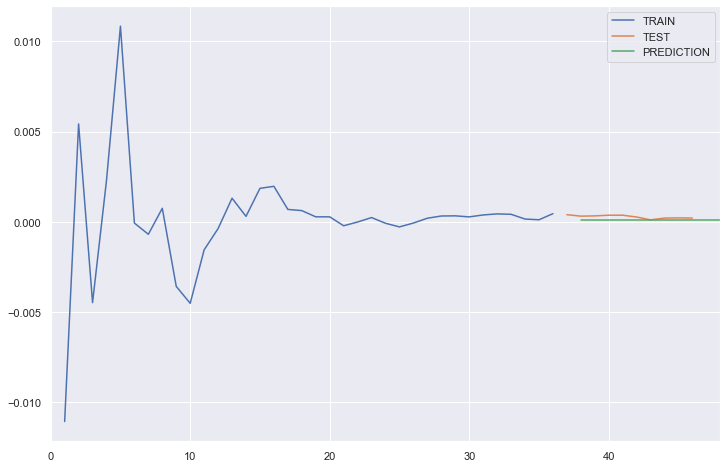

In [1441]:
# Exponential smoothing
model_t = SimpleExpSmoothing(train_set_t['CFR_diff'][1:]).fit()
test_predictions_t = model_t.forecast(len(test_set_g))
train_set_t['CFR_diff'].plot(legend=True,label='TRAIN')
test_set_t['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions_t.plot(legend=True,label='PREDICTION');

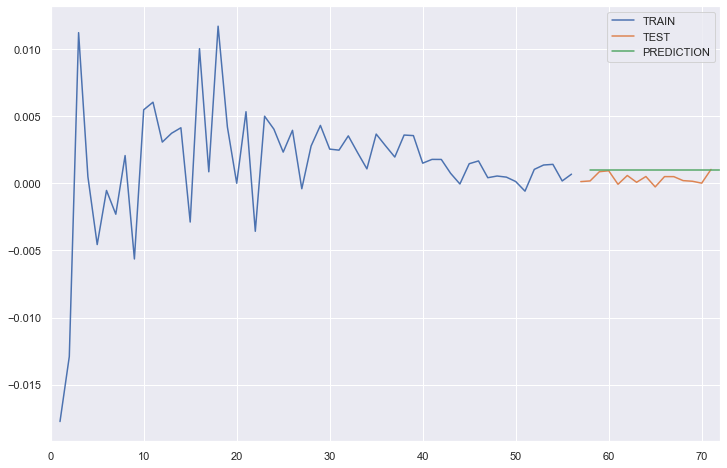

In [1442]:
model_r = SimpleExpSmoothing(train_set_r['CFR_diff'][1:]).fit()
test_predictions_r = model_r.forecast(len(test_set_r))
train_set_r['CFR_diff'].plot(legend=True,label='TRAIN')
test_set_r['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions_r.plot(legend=True,label='PREDICTION');

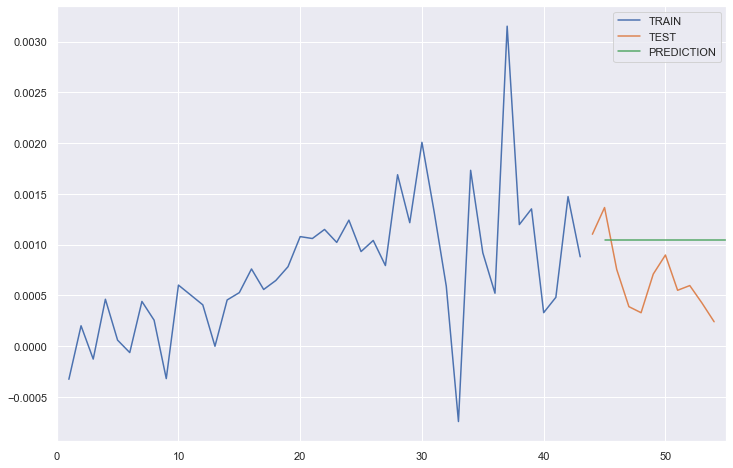

In [1443]:
model_g = SimpleExpSmoothing(train_set_g['CFR_diff'][1:]).fit()
test_predictions_g = model_g.forecast(len(test_set_g))
train_set_g['CFR_diff'].plot(legend=True,label='TRAIN')
test_set_g['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions_g.plot(legend=True,label='PREDICTION');

In [1445]:
model_exp_RMSE_t = RMSE(test_predictions_t, test_set_t.CFR_diff)
model_exp_RMSE_r = RMSE(test_predictions_r, test_set_r.CFR_diff)
model_exp_RMSE_g = RMSE(test_predictions_g, test_set_g.CFR_diff)

In [1446]:
modelResults_t.loc[2,"Model"] = "Exp Sm"
modelResults_t.loc[2,"Forecast"] = "Ep Sm"
modelResults_t.loc[2,"RMSE"] = model_exp_RMSE_t
modelResults_t.head()

Model Forecast RMSE
0    Mean     0.00 0.00
1  Linear   Linear 0.00
2  Exp Sm    Ep Sm 0.00

In [1447]:
modelResults_r.loc[2,"Model"] = "Exp Sm"
modelResults_r.loc[2,"Forecast"] = "Ep Sm"
modelResults_r.loc[2,"RMSE"] = model_exp_RMSE_r
modelResults_r.head()

Model Forecast RMSE
0    Mean     0.00 0.00
1  Linear   Linear 0.00
2  Exp Sm    Ep Sm 0.00

In [1448]:
modelResults_g.loc[2,"Model"] = "Exp Sm"
modelResults_g.loc[2,"Forecast"] = "Ep Sm"
modelResults_g.loc[2,"RMSE"] = model_exp_RMSE_g
modelResults_g.head()

Model Forecast RMSE
0    Mean     0.00 0.00
1  Linear   Linear 0.00
2  Exp Sm    Ep Sm 0.00

Double exponential smoothing. Помимо $\alpha$ -- сглаживающего фактора для уровня, добавляется сглаживающий фактор для тренда - -$\beta$.

In [1449]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [1450]:
double_model_t = ExponentialSmoothing(train_set_t['CFR_diff'][1:],trend='add').fit()
double_predictions_t = double_model_t.forecast(len(test_set_t))

train_set_t['CFR_diff'].plot(legend=True,label='TRAIN')
test_set_t['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
double_predictions_t.plot(legend=True,label='PREDICTION');

In [1451]:
double_model_r = ExponentialSmoothing(train_set_r['CFR_diff'][1:],trend='add').fit()
double_predictions_r = double_model_r.forecast(len(test_set_r))

train_set_r['CFR_diff'].plot(legend=True,label='TRAIN')
test_set_r['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
double_predictions_r.plot(legend=True,label='PREDICTION');

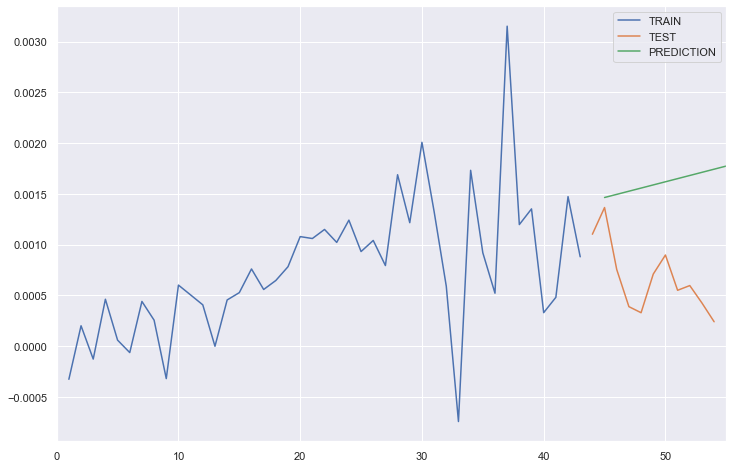

In [1453]:
double_model_g = ExponentialSmoothing(train_set_g['CFR_diff'][1:],trend='add').fit()
double_predictions_g = double_model_g.forecast(len(test_set_g))

train_set_g['CFR_diff'].plot(legend=True,label='TRAIN')
test_set_g['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
double_predictions_g.plot(legend=True,label='PREDICTION');

In [1455]:
model_exp2_RMSE_t = RMSE(double_predictions_t, test_set_t.CFR_diff)
model_exp2_RMSE_r = RMSE(double_predictions_r, test_set_r.CFR_diff)
model_exp2_RMSE_g = RMSE(double_predictions_g, test_set_g.CFR_diff)

In [1456]:
modelResults_t.loc[3,"Model"] = "2Exp Sm"
modelResults_t.loc[3,"Forecast"] = "2Ep Sm"
modelResults_t.loc[3,"RMSE"] = model_exp2_RMSE_t
modelResults_t.head()

Model Forecast RMSE
0     Mean     0.00 0.00
1   Linear   Linear 0.00
2   Exp Sm    Ep Sm 0.00
3  2Exp Sm   2Ep Sm 0.00

In [1457]:
modelResults_r.loc[3,"Model"] = "2Exp Sm"
modelResults_r.loc[3,"Forecast"] = "2Ep Sm"
modelResults_r.loc[3,"RMSE"] = model_exp2_RMSE_r
modelResults_r.head()

Model Forecast RMSE
0     Mean     0.00 0.00
1   Linear   Linear 0.00
2   Exp Sm    Ep Sm 0.00
3  2Exp Sm   2Ep Sm 0.00

In [1458]:
modelResults_g.loc[3,"Model"] = "2Exp Sm"
modelResults_g.loc[3,"Forecast"] = "2Ep Sm"
modelResults_g.loc[3,"RMSE"] = model_exp2_RMSE_g
modelResults_g.head()

Model Forecast RMSE
0     Mean     0.00 0.00
1   Linear   Linear 0.00
2   Exp Sm    Ep Sm 0.00
3  2Exp Sm   2Ep Sm 0.00

Triple exponential smoothing. В данной модели также учитывается фактор для сезонности. Это не совсем релевантно для данной задачи, по крайней мере на таком временном ряду.

#### 2.4 Скользящее среднее (MA - Moving average)

Поэксперементируйте с гиперпараметрами модели.

Simple Moving Average (SMA) использует скользящее окно, чтобы взять среднее за установленное количество периодов времени, при этом это одинаково взвешенное предыдущих n периодов.

Возьмем окно 3.

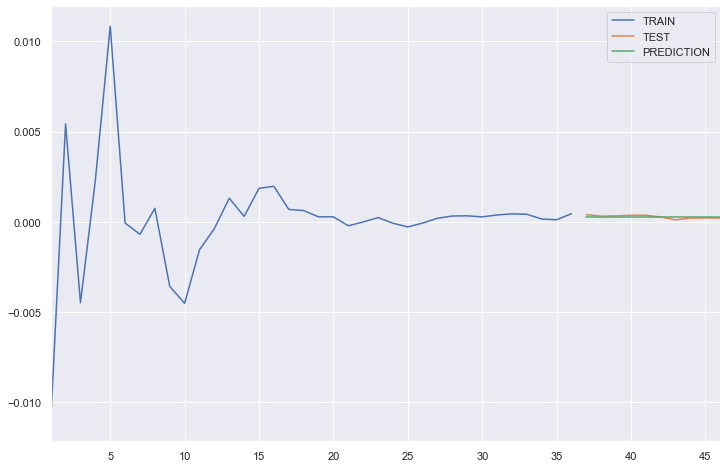

In [1459]:
test_set_t["moving_avg_forecast"] = train_set_t['CFR_diff'][1:].rolling(3).mean().iloc[-1]

train_set_t['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_t['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
test_set_t["moving_avg_forecast"].plot(legend=True,label='PREDICTION');

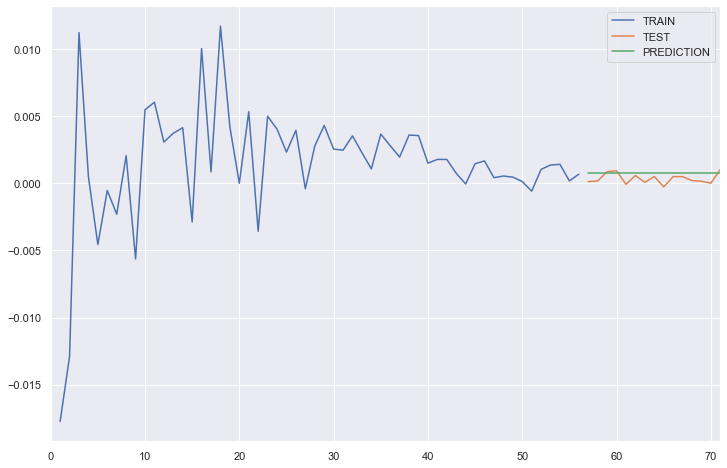

In [1460]:
test_set_r["moving_avg_forecast"] = train_set_r['CFR_diff'][1:].rolling(3).mean().iloc[-1]

train_set_r['CFR_diff'].plot(legend=True,label='TRAIN')
test_set_r['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
test_set_r["moving_avg_forecast"].plot(legend=True,label='PREDICTION');

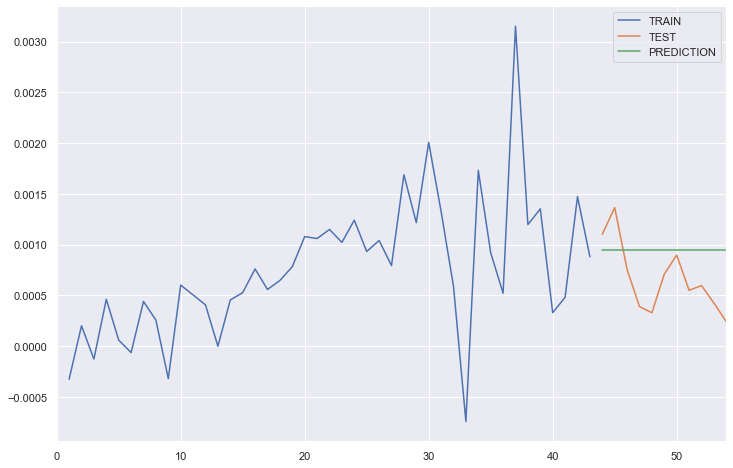

In [1461]:
test_set_g["moving_avg_forecast"] = train_set_g['CFR_diff'][1:].rolling(3).mean().iloc[-1]

train_set_g['CFR_diff'].plot(legend=True,label='TRAIN')
test_set_g['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
test_set_g["moving_avg_forecast"].plot(legend=True,label='PREDICTION');

In [1462]:
model_MA_RMSE_t = RMSE(test_set_t["moving_avg_forecast"], test_set_t['CFR_diff'])
model_MA_RMSE_r = RMSE(test_set_r["moving_avg_forecast"], test_set_r.CFR_diff)
model_MA_RMSE_g = RMSE(test_set_g["moving_avg_forecast"], test_set_g.CFR_diff)

In [1463]:
modelResults_t.loc[4,"Model"] = "MA_3"
modelResults_t.loc[4,"Forecast"] = test_set_t["moving_avg_forecast"][:1][37]
modelResults_t.loc[4,"RMSE"] = model_MA_RMSE_t
modelResults_t.head()

Model Forecast RMSE
0     Mean     0.00 0.00
1   Linear   Linear 0.00
2   Exp Sm    Ep Sm 0.00
3  2Exp Sm   2Ep Sm 0.00
4     MA_3     0.00 0.00

In [1464]:
modelResults_r.loc[4,"Model"] = "MA_3"
modelResults_r.loc[4,"Forecast"] = test_set_r["moving_avg_forecast"][:1][57]
modelResults_r.loc[4,"RMSE"] = model_MA_RMSE_r
modelResults_r.head()

Model Forecast RMSE
0     Mean     0.00 0.00
1   Linear   Linear 0.00
2   Exp Sm    Ep Sm 0.00
3  2Exp Sm   2Ep Sm 0.00
4     MA_3     0.00 0.00

In [1465]:
modelResults_g.loc[4,"Model"] = "2Exp Sm"
modelResults_g.loc[4,"Forecast"] = "2Ep Sm"
modelResults_g.loc[4,"RMSE"] = test_set_g["moving_avg_forecast"][:1][44]
modelResults_g.head()

Model Forecast RMSE
0     Mean     0.00 0.00
1   Linear   Linear 0.00
2   Exp Sm    Ep Sm 0.00
3  2Exp Sm   2Ep Sm 0.00
4  2Exp Sm   2Ep Sm 0.00

Возьмем окно 10.

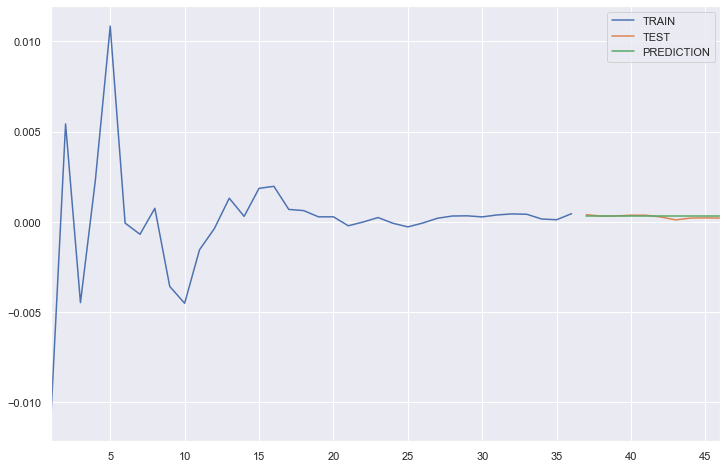

In [1466]:
test_set_t["moving_avg_forecast_10"] = train_set_t['CFR_diff'].rolling(10).mean().iloc[-1]

train_set_t['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_t['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
test_set_t["moving_avg_forecast_10"].plot(legend=True,label='PREDICTION');

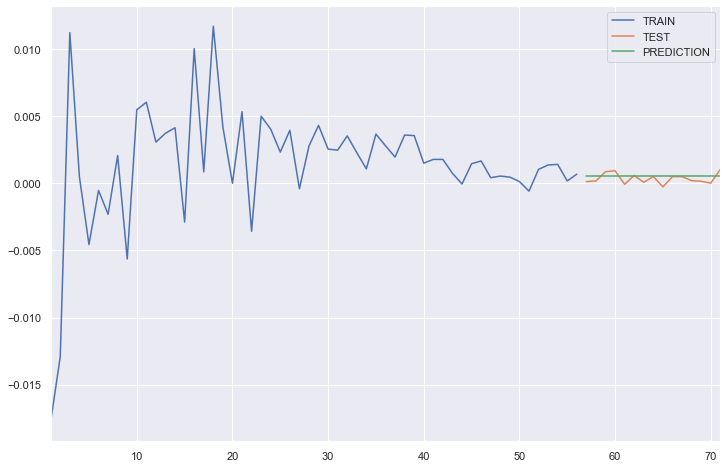

In [1467]:
test_set_r["moving_avg_forecast_10"] = train_set_r['CFR_diff'].rolling(10).mean().iloc[-1]

train_set_r['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_r['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
test_set_r["moving_avg_forecast_10"].plot(legend=True,label='PREDICTION');

In [1468]:
test_set_g["moving_avg_forecast_10"] = train_set_g['CFR_diff'].rolling(10).mean().iloc[-1]

train_set_g['CFR_diff'].plot(legend=True,label='TRAIN')
test_set_g['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
test_set_g["moving_avg_forecast_10"].plot(legend=True,label='PREDICTION');

In [1472]:
model_MA10_RMSE_t = RMSE(test_set_t["moving_avg_forecast_10"], test_set_t.CFR_diff)
model_MA10_RMSE_r = RMSE(test_set_r["moving_avg_forecast_10"], test_set_r.CFR_diff)
model_MA10_RMSE_g = RMSE(test_set_g["moving_avg_forecast_10"], test_set_g.CFR_diff)

In [1473]:
modelResults_t.loc[5,"Model"] = "MA_10"
modelResults_t.loc[5,"Forecast"] = test_set_t["moving_avg_forecast_10"][:1][37]
modelResults_t.loc[5,"RMSE"] = model_MA10_RMSE_t
modelResults_t

Model Forecast RMSE
0     Mean     0.00 0.00
1   Linear   Linear 0.00
2   Exp Sm    Ep Sm 0.00
3  2Exp Sm   2Ep Sm 0.00
4     MA_3     0.00 0.00
5    MA_10     0.00 0.00

In [1474]:
modelResults_r.loc[5,"Model"] = "MA_10"
modelResults_r.loc[5,"Forecast"] = test_set_r["moving_avg_forecast_10"][:1][57]
modelResults_r.loc[5,"RMSE"] = model_MA10_RMSE_r
modelResults_r

Model Forecast RMSE
0     Mean     0.00 0.00
1   Linear   Linear 0.00
2   Exp Sm    Ep Sm 0.00
3  2Exp Sm   2Ep Sm 0.00
4     MA_3     0.00 0.00
5    MA_10     0.00 0.00

In [1475]:
modelResults_g.loc[5,"Model"] = "MA_10"
modelResults_g.loc[5,"Forecast"] = test_set_g["moving_avg_forecast_10"][:1][44]
modelResults_g.loc[5,"RMSE"] = model_MA10_RMSE_g
modelResults_g

Model Forecast RMSE
0     Mean     0.00 0.00
1   Linear   Linear 0.00
2   Exp Sm    Ep Sm 0.00
3  2Exp Sm   2Ep Sm 0.00
4  2Exp Sm   2Ep Sm 0.00
5    MA_10     0.00 0.00

In [1029]:
# Брать окно больше не имеет смысла, ситуация зависит больше от нескольких прошедших дней. 

#### 2.5 Авторегрессионная модель (AR - Autoregressive model)

Поэксперементируйте с гиперпараметрами модели.

Модель авторгерессии использует лагированые переменные в качестве инпута. 

In [1476]:
# Ваш код здесь
from statsmodels.tsa.ar_model import AR

In [1477]:
model_t = AR(train_set_t["CFR_diff"][1:])
model_fitted_t = model_t.fit()
predictions_t = model_fitted_t.predict(start=len(train_set_t[1:]), end=len(train_set_t[1:]) + len(test_set_t)-1, dynamic=False)
print('The lag value chose is: %s' % model_fitted_t.k_ar)
print('The coefficients of the model are:\n %s' % model_fitted_t.params)

The lag value chose is: 9
The coefficients of the model are:
 const          0.00
L1.CFR_diff    0.32
L2.CFR_diff   -0.01
L3.CFR_diff    0.09
L4.CFR_diff    0.11
L5.CFR_diff   -0.47
L6.CFR_diff    0.05
L7.CFR_diff   -0.07
L8.CFR_diff    0.16
L9.CFR_diff   -0.07
dtype: float64


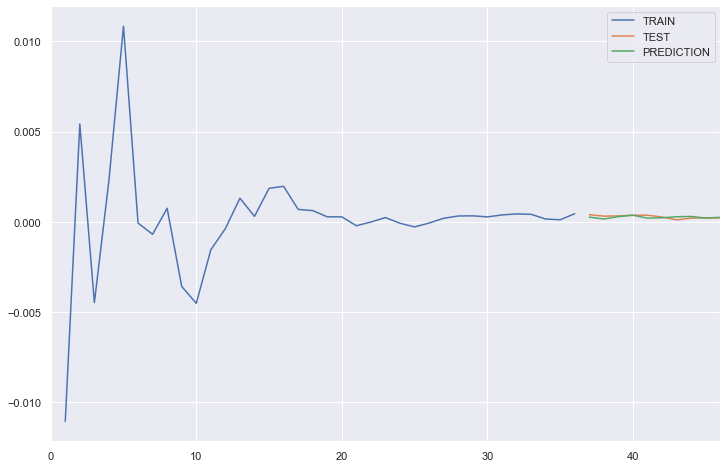

In [1485]:
train_set_t['CFR_diff'].plot(legend=True,label='TRAIN')
test_set_t['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
predictions_t.plot(legend=True,label='PREDICTION');

In [1486]:
model_r = AR(train_set_r["CFR_diff"][1:])
model_fitted_r = model_r.fit()
predictions_r = model_fitted_r.predict(start=len(train_set_r[1:]), end=len(train_set_r[1:]) + len(test_set_r)-1, dynamic=False)
print('The lag value chose is: %s' % model_fitted_r.k_ar)
print('The coefficients of the model are:\n %s' % model_fitted_r.params)

The lag value chose is: 10
The coefficients of the model are:
 const           0.00
L1.CFR_diff    -0.22
L2.CFR_diff     0.57
L3.CFR_diff     0.16
L4.CFR_diff    -0.33
L5.CFR_diff     0.14
L6.CFR_diff     0.33
L7.CFR_diff     0.12
L8.CFR_diff     0.03
L9.CFR_diff    -0.29
L10.CFR_diff   -0.24
dtype: float64


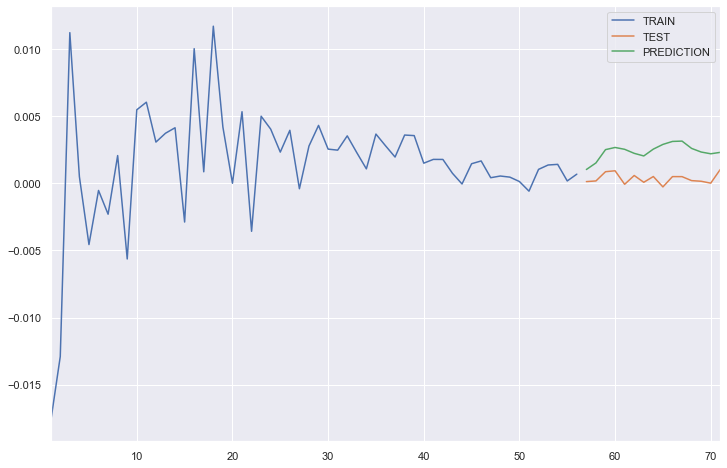

In [1487]:
train_set_r['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_r['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
predictions_r.plot(legend=True,label='PREDICTION');

In [1488]:
model_g = AR(train_set_g["CFR_diff"][1:])
model_fitted_g = model_g.fit()
predictions_g = model_fitted_g.predict(start=len(train_set_g[1:]), end=len(train_set_g[1:]) + len(test_set_g)-1, dynamic=False)
print('The lag value chose is: %s' % model_fitted_g.k_ar)
print('The coefficients of the model are:\n %s' % model_fitted_g.params)

The lag value chose is: 10
The coefficients of the model are:
 const           0.00
L1.CFR_diff    -0.18
L2.CFR_diff     0.02
L3.CFR_diff     0.12
L4.CFR_diff    -0.22
L5.CFR_diff    -0.11
L6.CFR_diff     0.02
L7.CFR_diff     0.49
L8.CFR_diff     0.42
L9.CFR_diff     0.09
L10.CFR_diff   -0.08
dtype: float64


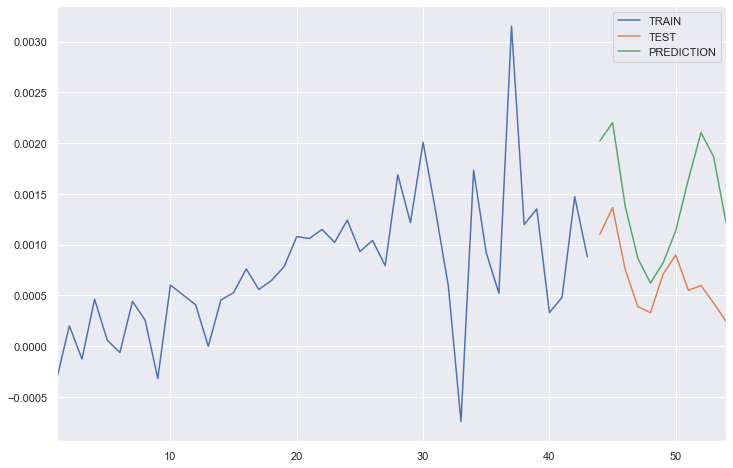

In [1489]:
train_set_g['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_g['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
predictions_g.plot(legend=True,label='PREDICTION');

In [1490]:
model_AR_RMSE_t = RMSE(test_set_t.CFR_diff, predictions_t)
model_AR_RMSE_r = RMSE(test_set_r.CFR_diff, predictions_r)
model_AR_RMSE_g = RMSE(test_set_g.CFR_diff, predictions_g)

In [1491]:
modelResults_g.loc[6,"Model"] = "AR"
modelResults_g.loc[6,"Forecast"] = "AR"
modelResults_g.loc[6,"RMSE"] = model_AR_RMSE_g
modelResults_g

Model Forecast RMSE
0     Mean     0.00 0.00
1   Linear   Linear 0.00
2   Exp Sm    Ep Sm 0.00
3  2Exp Sm   2Ep Sm 0.00
4  2Exp Sm   2Ep Sm 0.00
5    MA_10     0.00 0.00
6       AR       AR 0.00

In [1492]:
modelResults_r.loc[6,"Model"] = "AR"
modelResults_r.loc[6,"Forecast"] = "AR"
modelResults_r.loc[6,"RMSE"] = model_AR_RMSE_r
modelResults_r

Model Forecast RMSE
0     Mean     0.00 0.00
1   Linear   Linear 0.00
2   Exp Sm    Ep Sm 0.00
3  2Exp Sm   2Ep Sm 0.00
4     MA_3     0.00 0.00
5    MA_10     0.00 0.00
6       AR       AR 0.00

In [1493]:
modelResults_t.loc[6,"Model"] = "AR"
modelResults_t.loc[6,"Forecast"] = "AR"
modelResults_t.loc[6,"RMSE"] = model_AR_RMSE_t
modelResults_t

Model Forecast RMSE
0     Mean     0.00 0.00
1   Linear   Linear 0.00
2   Exp Sm    Ep Sm 0.00
3  2Exp Sm   2Ep Sm 0.00
4     MA_3     0.00 0.00
5    MA_10     0.00 0.00
6       AR       AR 0.00

#### 2.6 ARMA

Поэксперементируйте с гиперпараметрами модели.

In [1494]:
from statsmodels.tsa.arima_model import ARMA

In [ ]:
# В начале части по графикам мы определили начальные приблежения параметров, воспользуемся также функцией 
# ``arma_order_select_ic``

In [1587]:
# resDiff = sm.tsa.arma_order_select_ic(train_set_t.CFR_diff, max_ar=7, max_ma=7, ic='aic', trend='c')
# print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

In [1495]:
arma_mod11t = sm.tsa.ARMA(train_set_t['CFR_diff'][1:], (5,1)).fit(disp=False)
predict_arma_mod11t = arma_mod11t.predict(start=len(train_set_t[1:]), end=len(train_set_t[1:]) + len(test_set_t)-1, dynamic=False)

print(arma_mod11t.params)
print(arma_mod11t.aic, arma_mod11t.bic, arma_mod11t.hqic)

const             0.00
ar.L1.CFR_diff   -0.55
ar.L2.CFR_diff   -0.00
ar.L3.CFR_diff    0.20
ar.L4.CFR_diff   -0.55
ar.L5.CFR_diff   -0.66
ma.L1.CFR_diff    1.00
dtype: float64
-325.8129683965701 -313.14481688892124 -321.3914442150884


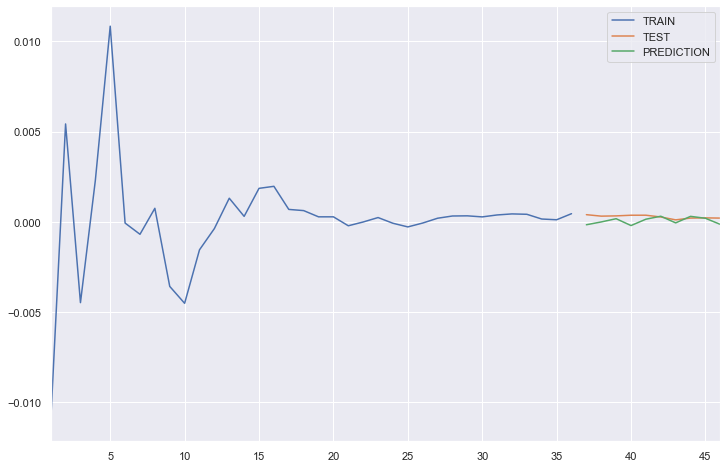

In [1496]:
train_set_t['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_t['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
predict_arma_mod11t.plot(legend=True,label='PREDICTION');

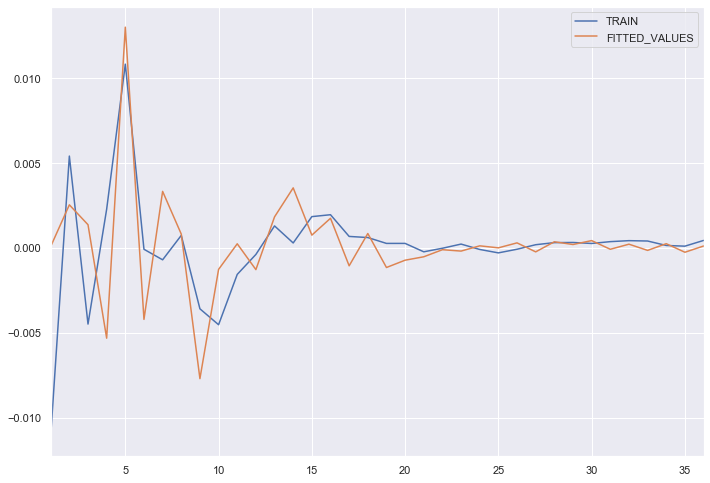

In [1497]:
# Посмотрим, насколько хорошо модель описывает данные
train_set_t['CFR_diff'][1:].plot(legend=True,label='TRAIN')
arma_mod11t.fittedvalues.plot(legend = True, label = "FITTED_VALUES");

In [1498]:
arma_mod21t = sm.tsa.ARMA(train_set_t['CFR_diff'][1:], (5,1)).fit(disp=False)
predict_arma_mod21t = arma_mod21t.predict(start=len(train_set_t[1:]), end=len(train_set_t[1:]) + len(test_set_t)-1, dynamic=False)

print(arma_mod21t.params)
print(arma_mod21t.aic, arma_mod11t.bic, arma_mod11t.hqic)

const             0.00
ar.L1.CFR_diff   -0.55
ar.L2.CFR_diff   -0.00
ar.L3.CFR_diff    0.20
ar.L4.CFR_diff   -0.55
ar.L5.CFR_diff   -0.66
ma.L1.CFR_diff    1.00
dtype: float64
-325.8129683965701 -313.14481688892124 -321.3914442150884


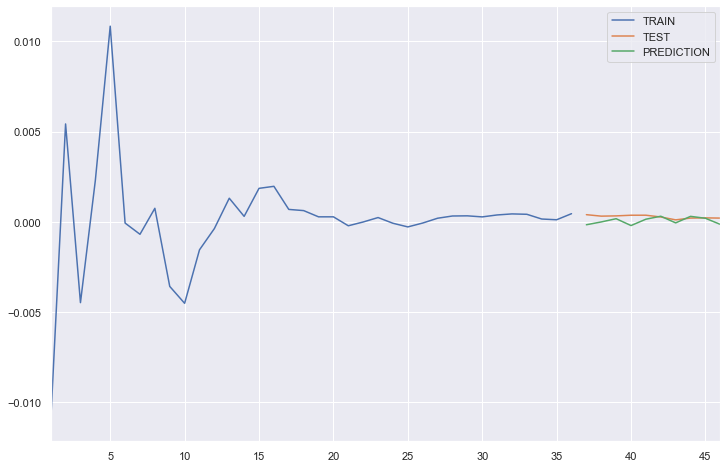

In [1499]:
train_set_t['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_t['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
predict_arma_mod21t.plot(legend=True,label='PREDICTION');

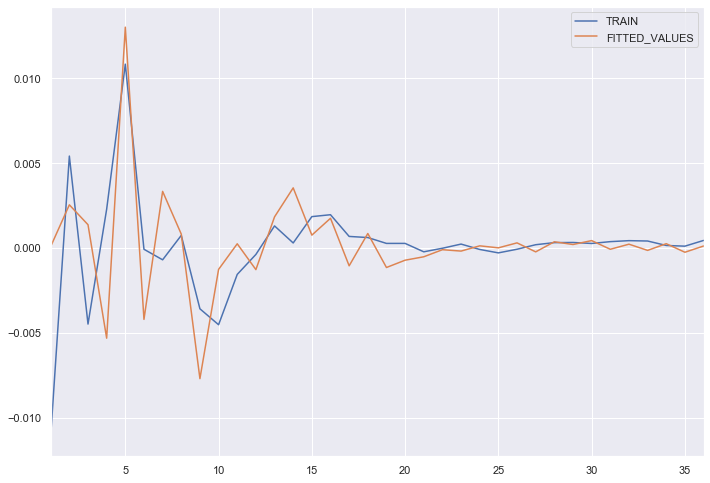

In [1501]:
train_set_t['CFR_diff'][1:].plot(legend=True,label='TRAIN')
arma_mod21t.fittedvalues.plot(legend=True,label='FITTED_VALUES');

In [1502]:
arma_mod11g = sm.tsa.ARMA(train_set_g['CFR_diff'][1:], (9,1)).fit(disp=False)
predict_arma_mod11g = arma_mod11g.predict(start=len(train_set_g[1:]), end=len(train_set_g[1:]) + len(test_set_g)-1, dynamic=False)

print(arma_mod11g.params)
print(arma_mod11g.aic, arma_mod11g.bic, arma_mod11g.hqic)

const             0.00
ar.L1.CFR_diff    0.87
ar.L2.CFR_diff    0.18
ar.L3.CFR_diff    0.09
ar.L4.CFR_diff   -0.29
ar.L5.CFR_diff    0.09
ar.L6.CFR_diff    0.14
ar.L7.CFR_diff    0.30
ar.L8.CFR_diff   -0.03
ar.L9.CFR_diff   -0.39
ma.L1.CFR_diff   -1.00
dtype: float64
-502.76766635379863 -481.63326496547586 -494.9739522854659


In [1503]:
train_set_g['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_g['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
predict_arma_mod11g.plot(legend=True,label='PREDICTION');

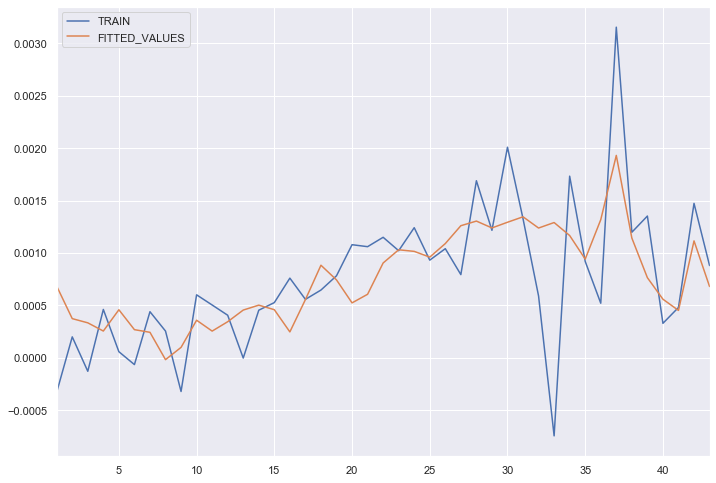

In [1504]:
train_set_g['CFR_diff'][1:].plot(legend=True,label='TRAIN')
arma_mod11g.fittedvalues.plot(legend=True,label='FITTED_VALUES');

In [1505]:
arma_mod21g = sm.tsa.ARMA(train_set_g['CFR_diff'][1:], (7,1)).fit(disp=False)
predict_arma_mod21g = arma_mod21g.predict(start=len(train_set_g[1:]), end=len(train_set_g[1:]) + len(test_set_g)-1, dynamic=False)

print(arma_mod21g.params)
print(arma_mod21g.aic, arma_mod11g.bic, arma_mod11g.hqic)

const             0.00
ar.L1.CFR_diff    0.32
ar.L2.CFR_diff    0.13
ar.L3.CFR_diff    0.12
ar.L4.CFR_diff   -0.21
ar.L5.CFR_diff    0.08
ar.L6.CFR_diff    0.09
ar.L7.CFR_diff    0.38
ma.L1.CFR_diff   -0.27
dtype: float64
-500.61634640937405 -481.63326496547586 -494.9739522854659


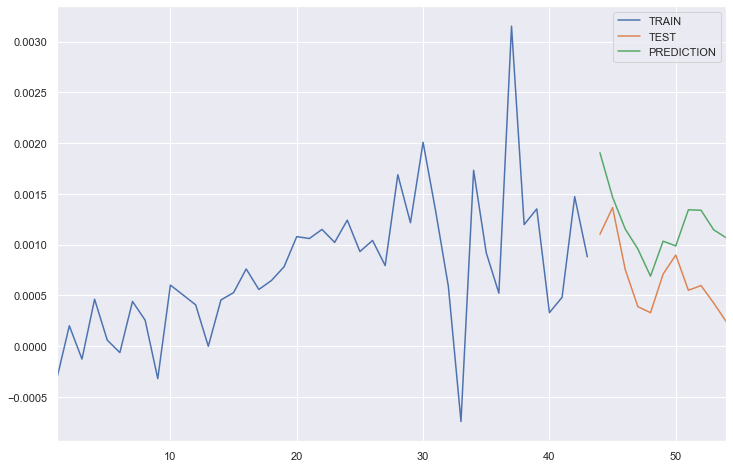

In [1506]:
train_set_g['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_g['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
predict_arma_mod21g.plot(legend=True,label='PREDICTION');

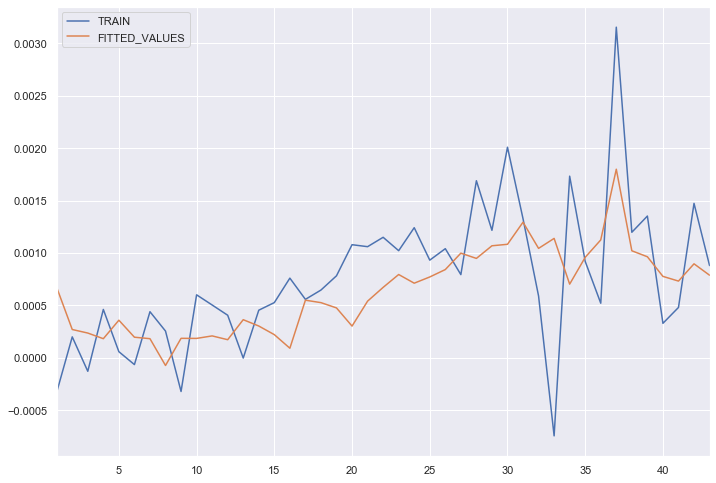

In [1507]:
train_set_g['CFR_diff'][1:].plot(legend=True,label='TRAIN')
arma_mod21g.fittedvalues.plot(legend=True,label='FITTED_VALUES');

In [1508]:
arma_mod11r = sm.tsa.ARMA(train_set_r['CFR_diff'][1:], (7,1)).fit(disp=False)
predict_arma_mod11r = arma_mod11r.predict(start=len(train_set_r[1:]), end=len(train_set_r[1:]) + len(test_set_r)-1, dynamic=False)

print(arma_mod11r.params)
print(arma_mod11r.aic, arma_mod11r.bic, arma_mod11r.hqic)

const             0.00
ar.L1.CFR_diff    0.26
ar.L2.CFR_diff   -0.23
ar.L3.CFR_diff    0.19
ar.L4.CFR_diff    0.10
ar.L5.CFR_diff    0.27
ar.L6.CFR_diff   -0.12
ar.L7.CFR_diff    0.32
ma.L1.CFR_diff   -0.20
dtype: float64
-435.92254213575177 -415.6690252284003 -428.07029646308024


In [1509]:
train_set_r['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_r['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
predict_arma_mod11r.plot(legend=True,label='PREDICTION');

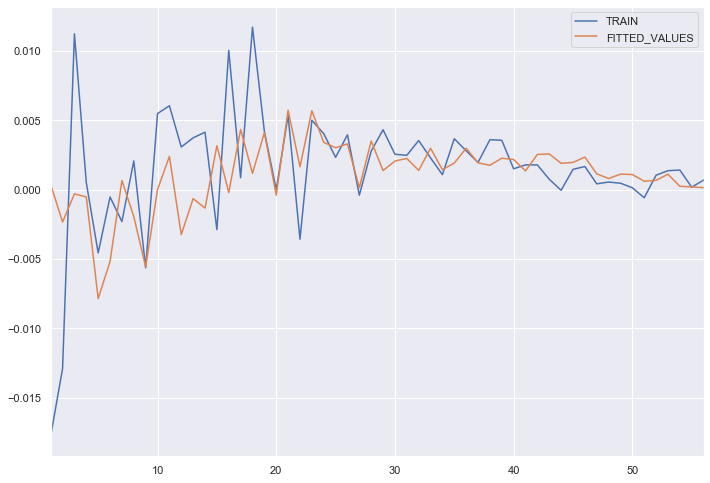

In [1510]:
train_set_r['CFR_diff'][1:].plot(legend=True,label='TRAIN')
arma_mod11r.fittedvalues.plot(legend=True,label='FITTED_VALUES');

In [1511]:
arma_mod21r = sm.tsa.ARMA(train_set_r['CFR_diff'][1:], (2,1)).fit(disp=False)
predict_arma_mod21r = arma_mod11r.predict(start=len(train_set_r[1:]), end=len(train_set_r[1:]) + len(test_set_r)-1, dynamic=False)

print(arma_mod11r.params)
print(arma_mod11r.aic, arma_mod11r.bic, arma_mod11r.hqic)

const             0.00
ar.L1.CFR_diff    0.26
ar.L2.CFR_diff   -0.23
ar.L3.CFR_diff    0.19
ar.L4.CFR_diff    0.10
ar.L5.CFR_diff    0.27
ar.L6.CFR_diff   -0.12
ar.L7.CFR_diff    0.32
ma.L1.CFR_diff   -0.20
dtype: float64
-435.92254213575177 -415.6690252284003 -428.07029646308024


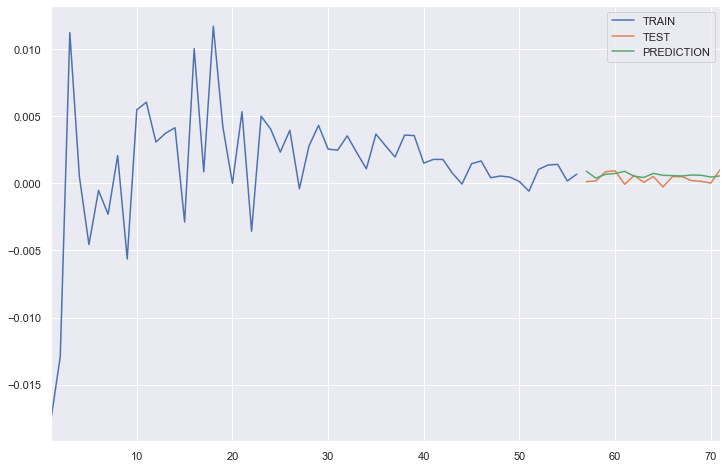

In [1512]:
train_set_r['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_r['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
predict_arma_mod21r.plot(legend=True,label='PREDICTION');

In [1515]:
model_ARMA11_RMSE_t = RMSE(predict_arma_mod11t, test_set_t.CFR_diff)
model_ARMA11_RMSE_r = RMSE(predict_arma_mod11r, test_set_r.CFR_diff)
model_ARMA11_RMSE_g = RMSE(predict_arma_mod11g, test_set_g.CFR_diff)

In [1516]:
model_ARMA21_RMSE_t = RMSE(predict_arma_mod21t, test_set_t.CFR_diff)
model_ARMA21_RMSE_r = RMSE(predict_arma_mod21r, test_set_r.CFR_diff)
model_ARMA21_RMSE_g = RMSE(predict_arma_mod21g, test_set_g.CFR_diff)

In [1517]:
modelResults_r.loc[7,"Model"] = "ARMA11"
modelResults_r.loc[7,"Forecast"] = "ARMA21"
modelResults_r.loc[7,"RMSE"] = model_ARMA11_RMSE_r
modelResults_r.loc[8,"Model"] = "ARMA21"
modelResults_r.loc[8,"Forecast"] = "ARMA21"
modelResults_r.loc[8,"RMSE"] = model_ARMA11_RMSE_r
modelResults_r

Model Forecast RMSE
0     Mean     0.00 0.00
1   Linear   Linear 0.00
2   Exp Sm    Ep Sm 0.00
3  2Exp Sm   2Ep Sm 0.00
4     MA_3     0.00 0.00
5    MA_10     0.00 0.00
6       AR       AR 0.00
7   ARMA11   ARMA21 0.00
8   ARMA21   ARMA21 0.00

In [1518]:
modelResults_t.loc[7,"Model"] = "ARMA11"
modelResults_t.loc[7,"Forecast"] = "ARMA21"
modelResults_t.loc[7,"RMSE"] = model_ARMA11_RMSE_t
modelResults_t.loc[8,"Model"] = "ARMA21"
modelResults_t.loc[8,"Forecast"] = "ARMA21"
modelResults_t.loc[8,"RMSE"] = model_ARMA11_RMSE_t
modelResults_t

Model Forecast RMSE
0     Mean     0.00 0.00
1   Linear   Linear 0.00
2   Exp Sm    Ep Sm 0.00
3  2Exp Sm   2Ep Sm 0.00
4     MA_3     0.00 0.00
5    MA_10     0.00 0.00
6       AR       AR 0.00
7   ARMA11   ARMA21 0.00
8   ARMA21   ARMA21 0.00

In [1519]:
modelResults_g.loc[7,"Model"] = "ARMA11"
modelResults_g.loc[7,"Forecast"] = "ARMA21"
modelResults_g.loc[7,"RMSE"] = model_ARMA11_RMSE_g
modelResults_g.loc[8,"Model"] = "ARMA21"
modelResults_g.loc[8,"Forecast"] = "ARMA21"
modelResults_g.loc[8,"RMSE"] = model_ARMA11_RMSE_g
modelResults_g

Model Forecast RMSE
0     Mean     0.00 0.00
1   Linear   Linear 0.00
2   Exp Sm    Ep Sm 0.00
3  2Exp Sm   2Ep Sm 0.00
4  2Exp Sm   2Ep Sm 0.00
5    MA_10     0.00 0.00
6       AR       AR 0.00
7   ARMA11   ARMA21 0.00
8   ARMA21   ARMA21 0.00

#### 2.7 Интегрированная модель авторегрессии — скользящего среднего (Auto Regressive Integrated Moving Average)

In [1589]:
from statsmodels.tsa.arima_model import ARIMA

In [1605]:
ps = range(0, 5)
qs = range(0, 5)
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

25

In [1637]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(train_set_t.CFR_diff, order=(param[0], 0, param[1]), 
                                        seasonal_order=(0, 0, 0, 0)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [1638]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

   parameters     aic
24     (4, 4) -337.70
20     (4, 0) -328.29
21     (4, 1) -328.08
22     (4, 2) -326.65
23     (4, 3) -324.61


In [1647]:
pred_t = best_model.predict(start = 36, end = 46)[1:]

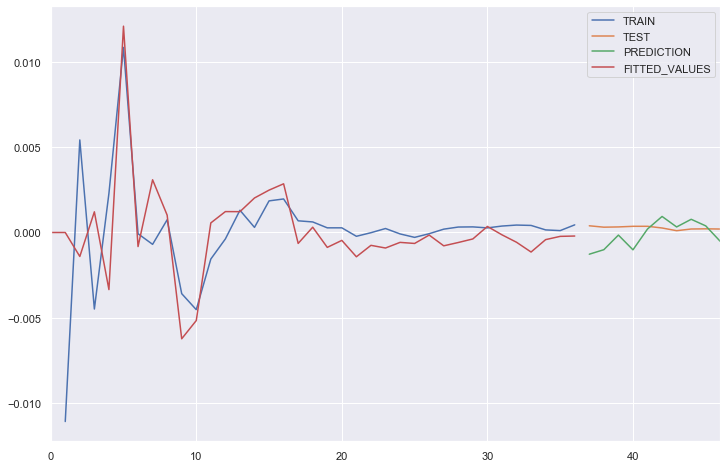

In [1648]:
train_set_t['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_t['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
pred_t.plot(legend = True, label = "PREDICTION")
best_model.fittedvalues.plot(legend=True,label='FITTED_VALUES');

In [1668]:
ps = range(0, 9)
qs = range(0, 7)
# d
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

63

In [1669]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(train_set_r.CFR_diff, order=(param[0], d, param[1]), 
                                        seasonal_order=(0, 0, 0, 0)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [1670]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

   parameters     aic
56     (8, 0) -417.44
59     (8, 3) -416.51
2      (0, 2) -415.46
28     (4, 0) -414.94
8      (1, 1) -414.53


In [1671]:
pred_r = best_model.predict(start = 57, end = 71)

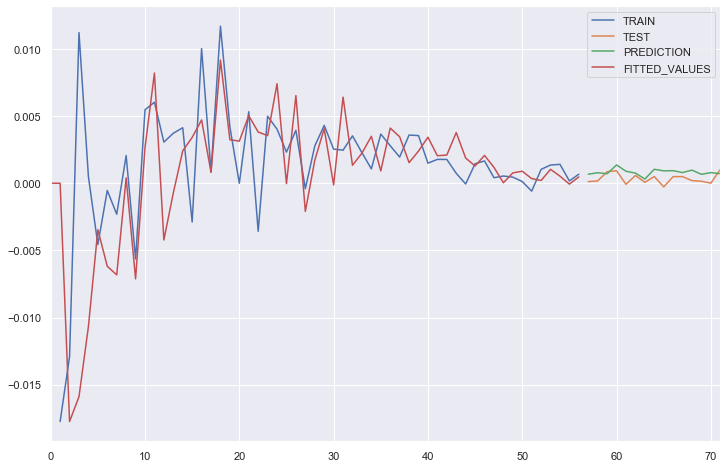

In [1672]:
train_set_r['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_r['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
pred_r.plot(legend = True, label = "PREDICTION")
best_model.fittedvalues.plot(legend=True,label='FITTED_VALUES');

In [1678]:
ps = range(0, 5)
qs = range(0, 7)
# d
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

35

In [1679]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(train_set_g.CFR_diff, order=(param[0], 0, param[1]), 
                                        seasonal_order=(0, 0, 0, 0)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [1680]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

   parameters     aic
15     (2, 1) -503.11
9      (1, 2) -503.03
12     (1, 5) -500.15
19     (2, 5) -499.97
21     (3, 0) -499.94


In [1681]:
pred_g = best_model.predict(start = 44, end = 54)

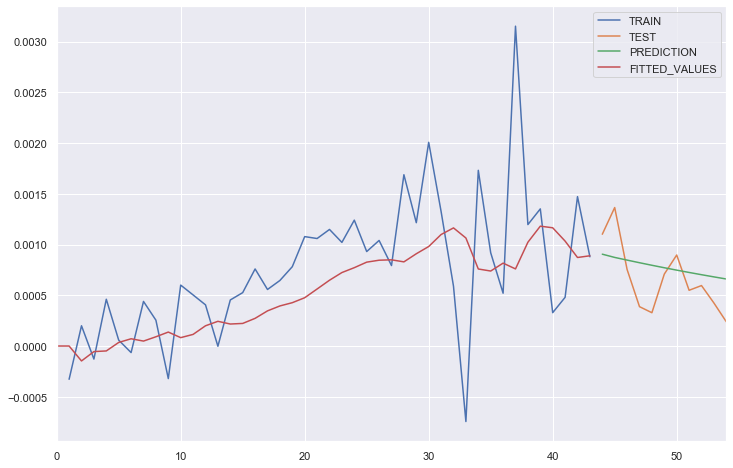

In [1682]:
train_set_g['CFR_diff'][1:].plot(legend=True,label='TRAIN')
test_set_g['CFR_diff'].plot(legend=True,label='TEST',figsize=(12,8))
pred_g.plot(legend = True, label = "PREDICTION")
best_model.fittedvalues.plot(legend=True,label='FITTED_VALUES');

In [1683]:
model_arima_rmse_t = RMSE(pred_t, test_set_t.CFR_diff)
model_arima_RMSE_r = RMSE(pred_r, test_set_r.CFR_diff)
model_arima_RMSE_g = RMSE(pred_g, test_set_g.CFR_diff)

In [1685]:
print(model_arima_rmse_t, model_arima_RMSE_r, model_arima_RMSE_g)

0.0008967922608712343 0.0006060266302473662 0.0003026937045501585


2.8 **SARIMA**

In [1738]:
ps = range(0, 5)
d=0
qs = range(0, 5)
Ps = range(0, 2)
D= 1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [1739]:
# Ваш код здесь
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(train_set_t.CFR_diff, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

UsageError: Line magic function `%%time` not found.


In [1740]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters     aic
1   (0, 0, 0, 1) -306.95
5   (0, 1, 0, 1) -305.30
17  (1, 1, 0, 1) -303.50
2   (0, 0, 1, 0) -303.30
0   (0, 0, 0, 0) -302.91


In [1741]:
print(best_model.summary())

                            Statespace Model Results                            
Dep. Variable:                 CFR_diff   No. Observations:                   57
Model:             SARIMAX(0, 1, 1, 12)   Log Likelihood                 155.474
Date:                  Wed, 06 May 2020   AIC                           -306.949
Time:                          04:48:05   BIC                           -303.335
Sample:                               0   HQIC                          -305.602
                                   - 57                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.7159      0.432     -1.657      0.097      -1.563       0.131
sigma2      2.912e-05   1.19e-05      2.447      0.014    5.79e-06    5.25e-05
Ljung-Box (Q):                      

In [1727]:
ps = range(0, 3)
d=0
qs = range(0, 3)
Ps = range(0, 2)
D= 1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [1728]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(train_set_r.CFR_diff, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [1729]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters     aic
1   (0, 0, 0, 1) -306.95
5   (0, 1, 0, 1) -305.30
17  (1, 1, 0, 1) -303.50
2   (0, 0, 1, 0) -303.30
0   (0, 0, 0, 0) -302.91


In [1730]:
print(best_model.summary())

                            Statespace Model Results                            
Dep. Variable:                 CFR_diff   No. Observations:                   57
Model:             SARIMAX(0, 1, 1, 12)   Log Likelihood                 155.474
Date:                  Wed, 06 May 2020   AIC                           -306.949
Time:                          04:45:40   BIC                           -303.335
Sample:                               0   HQIC                          -305.602
                                   - 57                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.7159      0.432     -1.657      0.097      -1.563       0.131
sigma2      2.912e-05   1.19e-05      2.447      0.014    5.79e-06    5.25e-05
Ljung-Box (Q):                      

In [1724]:
ps = range(0, 1)
d=0
qs = range(0, 1)
Ps = range(0, 2)
D= 1
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

4

In [1725]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(train_set_g.CFR_diff, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [1726]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

# Что-то пошло не так ...

     parameters     aic
0  (0, 0, 0, 0) -332.37
1  (0, 0, 1, 0) -330.51


In [1731]:
print(best_model.summary())

                            Statespace Model Results                            
Dep. Variable:                 CFR_diff   No. Observations:                   57
Model:             SARIMAX(0, 1, 1, 12)   Log Likelihood                 155.474
Date:                  Wed, 06 May 2020   AIC                           -306.949
Time:                          04:45:40   BIC                           -303.335
Sample:                               0   HQIC                          -305.602
                                   - 57                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.7159      0.432     -1.657      0.097      -1.563       0.131
sigma2      2.912e-05   1.19e-05      2.447      0.014    5.79e-06    5.25e-05
Ljung-Box (Q):                      

#### 2.11 Выводы

<здесь место для ваших выводов>

#### 2.9 Библиотека Prophet
Попробуйте использовать библиотеку Prophet для предсказания временного ряда. [Документация](https://facebook.github.io/prophet/docs/quick_start.html).


In [1703]:
import pystan

In [1704]:
from fbprophet import Prophet

# Ваш код здесь

ModuleNotFoundError: No module named 'fbprophet'

#### 2.10 Линейная модель с регрессией (Linear Regression Model)

Какие признаки оказались наиболее значимыми?

                            OLS Regression Results                            
Dep. Variable:                    CFR   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     15.95
Date:                Wed, 06 May 2020   Prob (F-statistic):           0.000318
Time:                        01:52:11   Log-Likelihood:                 161.12
No. Observations:                  37   AIC:                            -318.2
Df Residuals:                      35   BIC:                            -315.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.855e-20   7.15e-21      3.994   

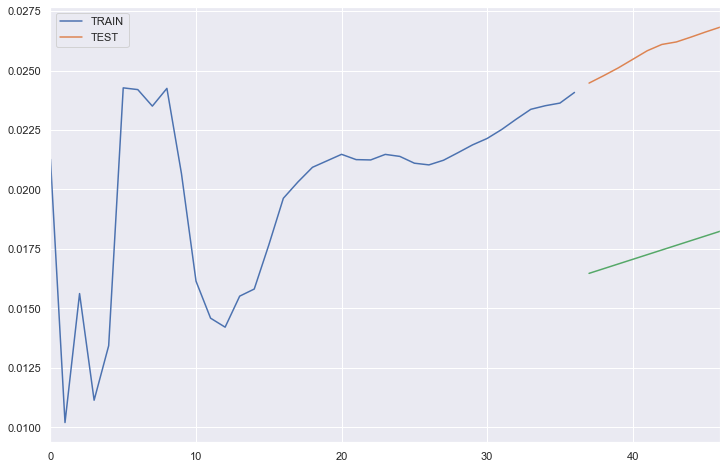

In [1561]:
model_lq_t = smf.ols('CFR ~ timeIndex + GDP + Life + Polity + Unemployment', data = train_set_t).fit()
model_lq_t_pred = model_lq_t.predict()[:len(test_set_t)]
print(model_lq_t.summary())
# Можем отметить, что коэффициенты при всех предикторах являются статистически значимыми. 

train_set_t['CFR'].plot(legend=True,label='TRAIN')
test_set_t['CFR'].plot(legend=True,label='TEST',figsize=(12,8))
plt.plot(test_set_t.timeIndex,model_lq_t_pred, '-')

                            OLS Regression Results                            
Dep. Variable:                    CFR   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     981.7
Date:                Wed, 06 May 2020   Prob (F-statistic):           9.36e-37
Time:                        01:54:27   Log-Likelihood:                 188.19
No. Observations:                  57   AIC:                            -372.4
Df Residuals:                      55   BIC:                            -368.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -9.076e-20    2.9e-21    -31.332   

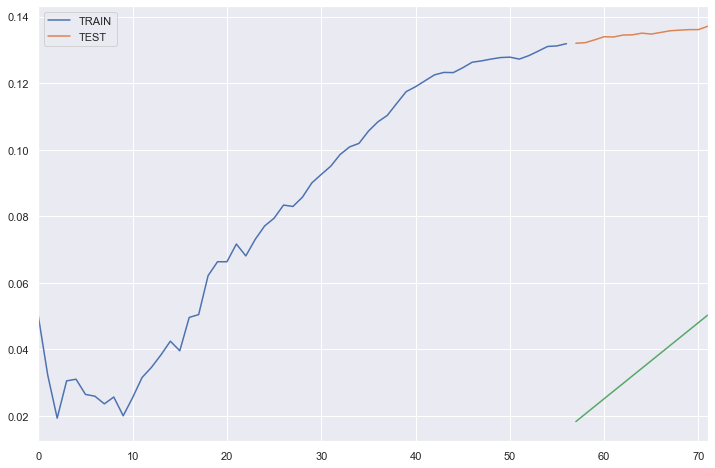

In [1568]:
model_lq_r = smf.ols('CFR ~ timeIndex + GDP + Life + Polity + Unemployment', data = train_set_r).fit()
model_lq_r_pred = model_lq_r.predict()[:len(test_set_r)]
print(model_lq_r.summary())
# Можем отметить, что коэффициенты при всех предикторах являются статистически значимыми. 

train_set_r['CFR'].plot(legend=True,label='TRAIN')
test_set_r['CFR'].plot(legend=True,label='TEST',figsize=(12,8))
plt.plot(test_set_r.timeIndex,model_lq_r_pred, '-')

                            OLS Regression Results                            
Dep. Variable:                    CFR   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     665.9
Date:                Wed, 06 May 2020   Prob (F-statistic):           2.18e-27
Time:                        01:55:15   Log-Likelihood:                 199.28
No. Observations:                  44   AIC:                            -394.6
Df Residuals:                      42   BIC:                            -391.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -6.983e-22   2.71e-23    -25.806   

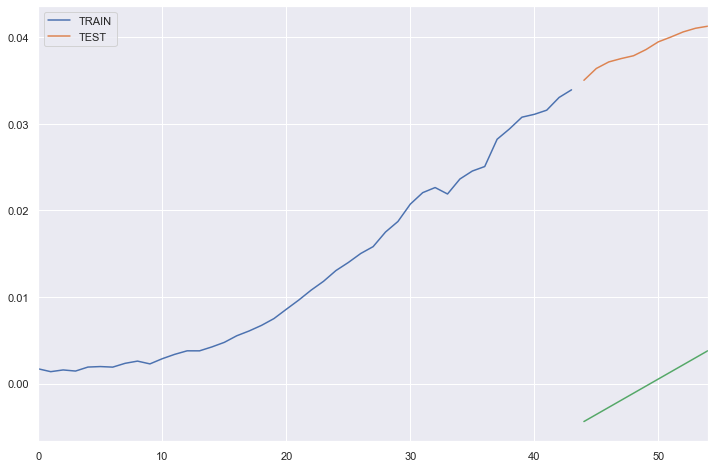

In [1569]:
model_lq_g = smf.ols('CFR ~ timeIndex + GDP + Life + Polity + Unemployment', data = train_set_g).fit()
model_lq_g_pred = model_lq_g.predict()[:len(test_set_g)]
print(model_lq_g.summary())
# Можем отметить, что коэффициенты при всех предикторах являются статистически значимыми. 

train_set_g['CFR'].plot(legend=True,label='TRAIN')
test_set_g['CFR'].plot(legend=True,label='TEST',figsize=(12,8))
plt.plot(test_set_g.timeIndex,model_lq_g_pred, '-')

In [0]:
# Ваш код здесь

2.11 **(Бонус) Используйте любую другую известную вам модель для предсказания.))**

![](https://lh3.googleusercontent.com/proxy/apcO3hDn7joDv-qU7Cz1gTc8zAvJpE3XmknjktN4OOyRnNwkcQf9nMfh26Be1McM9Hdd4PE3PP5ZIbUyvRb-q3wx-NE)

Будем использовать SARIMAX модель 

In [1705]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

C:\Users\Polina\Anaconda3\lib\site-packages\google\protobuf\descriptor.py:47: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working

C:\Users\Polina\Anaconda3\lib\site-packages\tensorflow_core\python\keras\backend.py:5851: ResourceWarning:

unclosed file <_io.TextIOWrapper name='C:\\Users\\Polina\\.keras\\keras.json' mode='r' encoding='cp1251'>

C:\Users\Polina\Anaconda3\lib\site-packages\botocore\awsrequest.py:624: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working



## Выводы по работе
<здесь место для ваших выводов>